In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'No OBV LSTM Time Series - cyclic'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from sklearn import preprocessing

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Cyclic Stocks

### Singapore Airlines

In [5]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14      OBV_7  labels
0  2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
1  2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2  2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
3  2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
4  2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0


In [6]:
df.set_index('Date', inplace=True)

In [7]:
df.drop(['OBV_7'], axis='columns', inplace=True)

In [8]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [9]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
X.shape

(4725, 15, 3)

In [10]:
v = X.reshape(X.shape[0],15, 3)
v[0]

array([[1.        , 1.        , 1.        ],
       [0.75999985, 0.92783951, 0.78504654],
       [0.64000015, 0.8402295 , 0.80601767],
       [0.48000031, 0.73069638, 0.17089513],
       [0.51999969, 0.64686477, 0.23230939],
       [0.6       , 0.59363121, 0.35514026],
       [0.71999969, 0.57513856, 0.56213184],
       [0.51999969, 0.51523893, 0.24368262],
       [0.48000031, 0.45570436, 0.20037465],
       [0.55999985, 0.42302965, 0.33794397],
       [0.35999985, 0.35112982, 0.06280271],
       [0.4       , 0.29914193, 0.1967527 ],
       [0.15999985, 0.20204974, 0.        ],
       [0.08000031, 0.1021941 , 0.11630365],
       [0.        , 0.        , 0.05751282]])

In [11]:
y = labels
y = np.array(y)
y.shape

(4725,)

In [12]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [13]:
SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "Close"

In [14]:
import time

EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [15]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [17]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 36ms/step - loss: 0.2876 - accuracy: 0.4892 - mse: 0.4761 - weighted_accuracy: 0.3372 - weighted_mse: 0.5377 - val_loss: 0.3002 - val_accuracy: 0.0455 - val_mse: 0.3517 - val_weighted_accuracy: 0.0455 - val_weighted_mse: 0.3517
Epoch 2/200
30/30 [==============================] - 0s 8ms/step - loss: 0.2072 - accuracy: 0.3463 - mse: 0.8354 - weighted_accuracy: 0.4457 - weighted_mse: 0.8276 - val_loss: 0.2899 - val_accuracy: 0.0455 - val_mse: 0.3807 - val_weighted_accuracy: 0.0455 - val_weighted_mse: 0.3807
Epoch 3/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1893 - accuracy: 0.3016 - mse: 1.0375 - weighted_accuracy: 0.4572 - weighted_mse: 1.0223 - val_loss: 0.2786 - val_accuracy: 0.0455 - val_mse: 0.4153 - val_weighted_accuracy: 0.0455 - val_weighted_mse: 0.4153
Epoch 4/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1824 - accuracy: 0.2646 - mse: 1.1511 - weighted_accuracy: 0.4806 - weighte

Epoch 30/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1438 - accuracy: 0.4056 - mse: 1.6306 - weighted_accuracy: 0.6674 - weighted_mse: 1.5571 - val_loss: 0.1937 - val_accuracy: 0.3852 - val_mse: 1.5990 - val_weighted_accuracy: 0.3852 - val_weighted_mse: 1.5990
Epoch 31/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1439 - accuracy: 0.4230 - mse: 1.6392 - weighted_accuracy: 0.6647 - weighted_mse: 1.5721 - val_loss: 0.1999 - val_accuracy: 0.3460 - val_mse: 1.7587 - val_weighted_accuracy: 0.3460 - val_weighted_mse: 1.7587
Epoch 32/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1417 - accuracy: 0.3836 - mse: 1.6651 - weighted_accuracy: 0.6779 - weighted_mse: 1.5901 - val_loss: 0.1796 - val_accuracy: 0.4720 - val_mse: 1.6601 - val_weighted_accuracy: 0.4720 - val_weighted_mse: 1.6601
Epoch 33/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1418 - accuracy: 0.4733 - mse: 1.6518 - weighted_accuracy: 0.6867 - weig

Epoch 59/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1240 - accuracy: 0.5304 - mse: 2.0320 - weighted_accuracy: 0.7687 - weighted_mse: 1.9953 - val_loss: 0.1758 - val_accuracy: 0.5026 - val_mse: 2.0858 - val_weighted_accuracy: 0.5026 - val_weighted_mse: 2.0858
Epoch 60/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1238 - accuracy: 0.5354 - mse: 2.0245 - weighted_accuracy: 0.7669 - weighted_mse: 1.9816 - val_loss: 0.1913 - val_accuracy: 0.4423 - val_mse: 2.0981 - val_weighted_accuracy: 0.4423 - val_weighted_mse: 2.0981
Epoch 61/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1227 - accuracy: 0.5452 - mse: 2.0436 - weighted_accuracy: 0.7705 - weighted_mse: 2.0137 - val_loss: 0.1951 - val_accuracy: 0.4127 - val_mse: 2.1485 - val_weighted_accuracy: 0.4127 - val_weighted_mse: 2.1485
Epoch 62/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1233 - accuracy: 0.5140 - mse: 2.0865 - weighted_accuracy: 0.7683 - 

30/30 [==============================] - 0s 11ms/step - loss: 0.1061 - accuracy: 0.6127 - mse: 2.4645 - weighted_accuracy: 0.8247 - weighted_mse: 2.4618 - val_loss: 0.1713 - val_accuracy: 0.5587 - val_mse: 2.5770 - val_weighted_accuracy: 0.5587 - val_weighted_mse: 2.5770
Epoch 88/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1066 - accuracy: 0.6384 - mse: 2.4926 - weighted_accuracy: 0.8268 - weighted_mse: 2.4698 - val_loss: 0.1995 - val_accuracy: 0.4751 - val_mse: 2.5965 - val_weighted_accuracy: 0.4751 - val_weighted_mse: 2.5965
Epoch 89/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1055 - accuracy: 0.6159 - mse: 2.5208 - weighted_accuracy: 0.8241 - weighted_mse: 2.5059 - val_loss: 0.1571 - val_accuracy: 0.6021 - val_mse: 2.5466 - val_weighted_accuracy: 0.6021 - val_weighted_mse: 2.5466
Epoch 90/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1061 - accuracy: 0.6243 - mse: 2.5263 - weighted_accuracy: 0.8106 - weighted_mse:

Epoch 116/200
30/30 [==============================] - 0s 12ms/step - loss: 0.0906 - accuracy: 0.6960 - mse: 3.1151 - weighted_accuracy: 0.8627 - weighted_mse: 3.1149 - val_loss: 0.1631 - val_accuracy: 0.6180 - val_mse: 3.2525 - val_weighted_accuracy: 0.6180 - val_weighted_mse: 3.2525
Epoch 117/200
30/30 [==============================] - 0s 11ms/step - loss: 0.0920 - accuracy: 0.7127 - mse: 3.1241 - weighted_accuracy: 0.8614 - weighted_mse: 3.1327 - val_loss: 0.2096 - val_accuracy: 0.4899 - val_mse: 3.2784 - val_weighted_accuracy: 0.4899 - val_weighted_mse: 3.2784
Epoch 118/200
30/30 [==============================] - 0s 11ms/step - loss: 0.0884 - accuracy: 0.6802 - mse: 3.1724 - weighted_accuracy: 0.8717 - weighted_mse: 3.1775 - val_loss: 0.1453 - val_accuracy: 0.6910 - val_mse: 3.1487 - val_weighted_accuracy: 0.6910 - val_weighted_mse: 3.1487
Epoch 119/200
30/30 [==============================] - 0s 12ms/step - loss: 0.0911 - accuracy: 0.7167 - mse: 3.1906 - weighted_accuracy: 0.862

Epoch 145/200
30/30 [==============================] - 0s 11ms/step - loss: 0.0765 - accuracy: 0.7526 - mse: 3.8823 - weighted_accuracy: 0.8871 - weighted_mse: 3.8894 - val_loss: 0.1862 - val_accuracy: 0.6053 - val_mse: 4.0926 - val_weighted_accuracy: 0.6053 - val_weighted_mse: 4.0926
Epoch 146/200
30/30 [==============================] - 0s 11ms/step - loss: 0.0782 - accuracy: 0.7526 - mse: 3.9033 - weighted_accuracy: 0.8945 - weighted_mse: 3.8925 - val_loss: 0.1690 - val_accuracy: 0.6307 - val_mse: 4.0620 - val_weighted_accuracy: 0.6307 - val_weighted_mse: 4.0620
Epoch 147/200
30/30 [==============================] - 0s 11ms/step - loss: 0.0759 - accuracy: 0.7579 - mse: 3.9540 - weighted_accuracy: 0.8946 - weighted_mse: 3.8997 - val_loss: 0.1743 - val_accuracy: 0.6476 - val_mse: 4.2389 - val_weighted_accuracy: 0.6476 - val_weighted_mse: 4.2389
Epoch 148/200
30/30 [==============================] - 0s 11ms/step - loss: 0.0804 - accuracy: 0.7532 - mse: 4.0005 - weighted_accuracy: 0.885

Epoch 174/200
30/30 [==============================] - 0s 11ms/step - loss: 0.0621 - accuracy: 0.8151 - mse: 4.9374 - weighted_accuracy: 0.9230 - weighted_mse: 4.8766 - val_loss: 0.1722 - val_accuracy: 0.6963 - val_mse: 5.1046 - val_weighted_accuracy: 0.6963 - val_weighted_mse: 5.1046
Epoch 175/200
30/30 [==============================] - 0s 11ms/step - loss: 0.0644 - accuracy: 0.8122 - mse: 4.9703 - weighted_accuracy: 0.9163 - weighted_mse: 4.8578 - val_loss: 0.1791 - val_accuracy: 0.6593 - val_mse: 5.0529 - val_weighted_accuracy: 0.6593 - val_weighted_mse: 5.0529
Epoch 176/200
30/30 [==============================] - 0s 11ms/step - loss: 0.0643 - accuracy: 0.8045 - mse: 5.0225 - weighted_accuracy: 0.9098 - weighted_mse: 4.9165 - val_loss: 0.1891 - val_accuracy: 0.6487 - val_mse: 5.1145 - val_weighted_accuracy: 0.6487 - val_weighted_mse: 5.1145
Epoch 177/200
30/30 [==============================] - 0s 11ms/step - loss: 0.0661 - accuracy: 0.7974 - mse: 4.9882 - weighted_accuracy: 0.905

In [18]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.20494812726974487
Test accuracy: 0.6677248477935791


In [19]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.4506375  -4.8819537   1.0638869 ]
 [-2.944121   -1.7848461   1.0300908 ]
 [-3.2555633  -1.0732538   0.06168062]
 ...
 [-1.3022918  -3.8742318   1.0983809 ]
 [-1.2394178  -4.0568743   0.68189466]
 [-2.6287389  -1.2474365   0.04440422]]


Counter({2: 677, 0: 104, 1: 164})

In [20]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 859, 0: 43, 1: 43})

In [21]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 945
actual predicted buys: 14
actual buys but predicted sell: 0
actual buys but predicted hold: 29
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 37
actual holds but predicted buy: 150
actual holds but predicted sell: 98
actual predicted holds: 611
Percentage buys correct: 32.55813953488372%
Percentage sells correct: 13.953488372093023%
Percentage holds correct: 71.12922002328288%
actual buys: 43
actual sells: 43
actual holds: 859


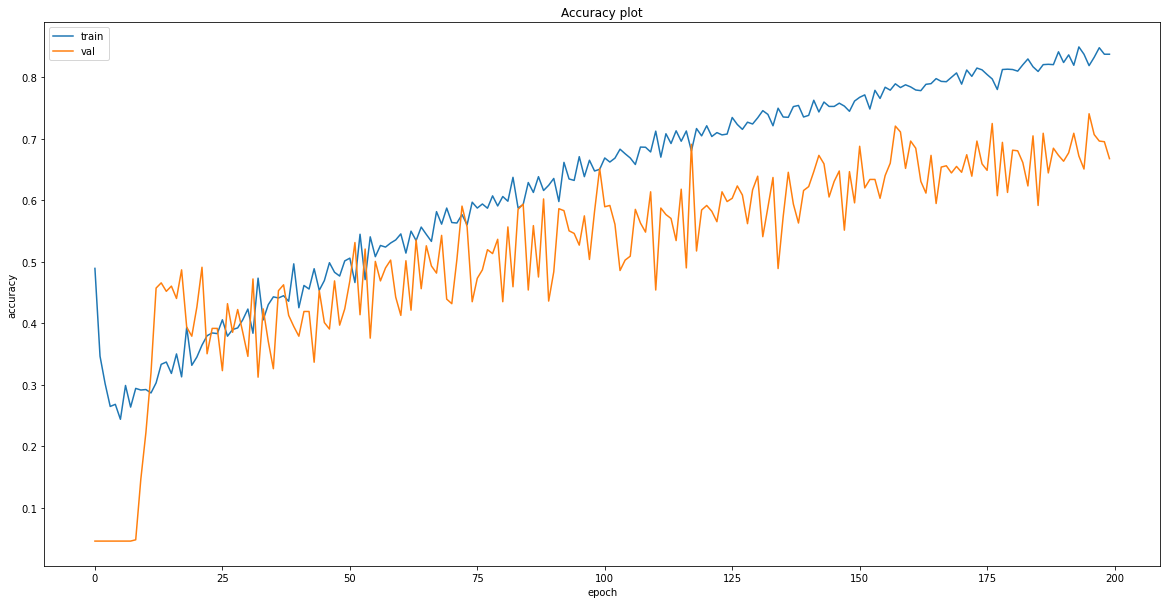

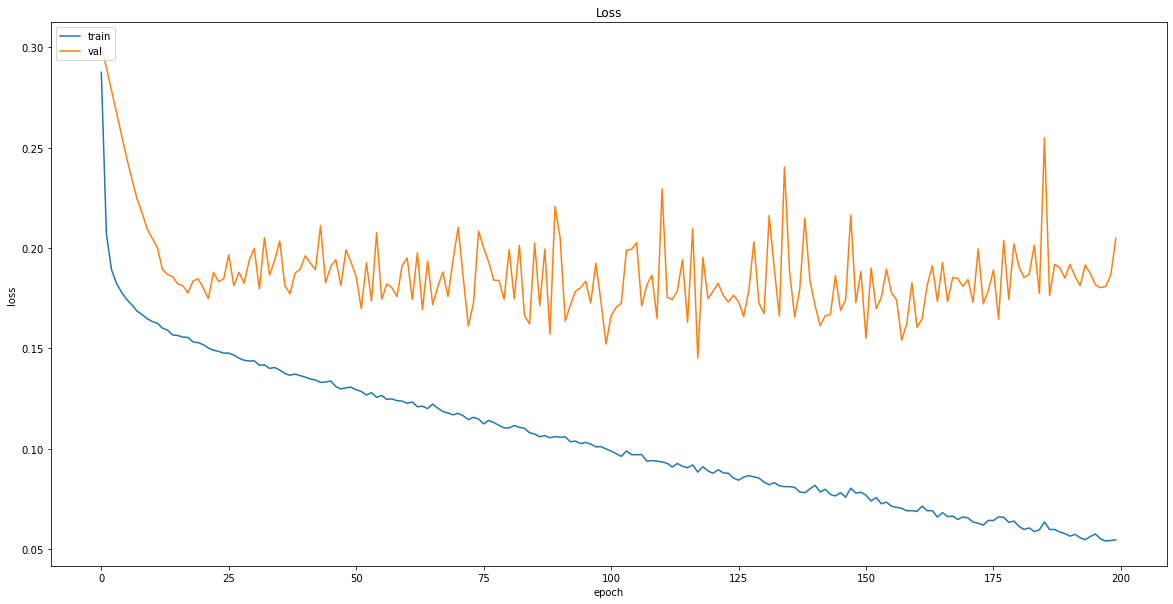

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
# Save model
model.save("models/{}".format('Singapore_Airlines_time_series_lstm_buy_hold_sell_no_obv.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/Singapore_Airlines_time_series_lstm_buy_hold_sell_no_obv.model\assets


### Test Performance

### non-recession

In [24]:
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
log  = pd.DataFrame(columns = column_names)
logger = []

In [25]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2019-01-21         9.59  9.538960 -32.758553  6890900.0     2.0
2019-01-22         9.63  9.552966 -25.862007  7759500.0     2.0
2019-01-23         9.61  9.561740 -29.310362  7108100.0     1.0
2019-01-24         9.50  9.552242 -48.275822  6126400.0     2.0
2019-01-25         9.74  9.581128  -8.888884  8160300.0     2.0


In [26]:
df.drop(['OBV_7'], axis='columns', inplace=True)

In [27]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [28]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(218, 15, 3)

In [29]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [30]:
model = tf.keras.models.load_model("models/Singapore_Airlines_time_series_lstm_buy_hold_sell_no_obv.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2115 - accuracy: 0.6009 - mean_squared_error: 6.1143 - weighted_accuracy: 0.6009 - weighted_mean_squared_error: 6.1143
Test loss: 0.21152356266975403
Test accuracy: 0.6009174585342407


In [31]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 141, 1: 56, 0: 21})

In [32]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 200, 0: 9, 1: 9})

In [33]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test.csv")
df.set_index('Date', inplace=True)

In [34]:
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df = df.iloc[13:]
df['predictions'] = predictions
df['actual'] = actual
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-08,9.76,9.644474,-45.454598,5084100.0,2.0,2,2
2019-02-11,9.71,9.662247,-15.151533,6464788.0,2.0,2,2
2019-02-12,9.65,9.669594,-30.303065,5675088.0,2.0,2,2
2019-02-13,9.73,9.666579,-48.484962,4337188.0,2.0,2,2
2019-02-14,9.87,9.676336,-32.000351,5826588.0,2.0,2,2


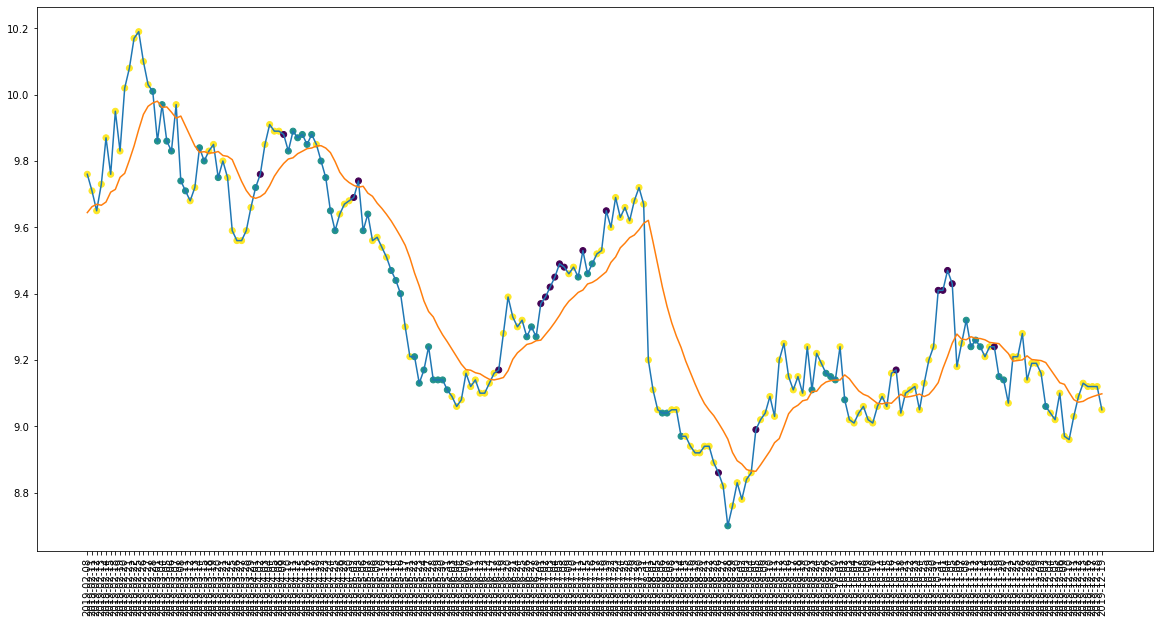

In [35]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [36]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 53
actual holds but predicted sell: 20
actual predicted holds: 127
Percentage buys correct: 33.333333333333336%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 63.5%
actual buys: 9
actual sells: 9
actual holds: 200


In [37]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[9.649999618530273, 9.710000038146973, 9.729999542236328, 9.760000228881836, 9.760000228881836, 9.829999923706056, 9.869999885559082, 9.949999809265137, 10.020000457763672]
[9.829999923706056, 9.949999809265137, 10.010000228881836, 10.020000457763672, 10.029999732971193, 10.079999923706056, 10.100000381469727, 10.170000076293944, 10.1899995803833]
Percentage buys correct: 58.92857142857143%
Percentage sells correct: 57.142857142857146%
Percentage holds correct: 78.72340425531915%


In [38]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $10.010000228881836
Shares owned at the moment: 996
Cash capital at the moment: $2.622381406783461


Stop Loss Activated!

Share price: $9.710000038146973
Shares owned at the moment: 0
Cash capital at the moment: $9647.186729296684


Share price: $9.710000038146973
Shares owned at the moment: 990
Cash capital at the moment: $7.851216427325198


Stop Loss Activated!

Share price: $9.4399995803833
Shares owned at the moment: 0
Cash capital at the moment: $9327.750402149199


Share price: $9.4399995803833
Shares owned at the moment: 985
Cash capital at the moment: $3.7802166082838085


Stop Loss Activated!

Share price: $9.130000114440918
Shares owned at the moment: 0
Cash capital at the moment: $8972.099441522596


Share price: $9.130000114440918
Shares owned at the moment: 980
Cash capital at the moment: $0.09397906207777851


Price increase from previously bought: 5.405638301585958%
Share price: $9.649999618530273
Shares owned at the moment: 0
Cash capital at the moment: $

In [39]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9222.27618237376
profit gained: -7.777238176262399%


In [40]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.600917,33.333333333333336%,11.11111111111111%,63.5%,58.92857142857143%,57.142857142857146%,78.72340425531915%,-9.125151241259664%,-7.777238176262399%


### Recession

In [41]:
logger = []

In [42]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-01-22         8.84  8.979182 -96.551645  -851200.0     2.0
2020-01-23         8.93  8.971615 -65.517105  1644900.0     2.0
2020-01-24         8.85  8.952905 -92.307523  -246900.0     2.0
2020-01-28         8.82  8.932458 -75.000000 -1718200.0     2.0
2020-01-29         8.56  8.875157 -86.885115 -5499900.0     2.0


In [43]:
df.drop(['OBV_7'], axis='columns', inplace=True)

In [44]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [45]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(215, 15, 3)

In [46]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [47]:
model = tf.keras.models.load_model("models/Singapore_Airlines_time_series_lstm_buy_hold_sell_no_obv.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 4ms/step - loss: 0.2424 - accuracy: 0.6744 - mean_squared_error: 7.3833 - weighted_accuracy: 0.6744 - weighted_mean_squared_error: 7.3833
Test loss: 0.2424120008945465
Test accuracy: 0.6744186282157898


In [48]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 153, 0: 11, 1: 51})

In [49]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [50]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test2.csv")
df.set_index('Date', inplace=True)

In [51]:
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df = df.iloc[13:]
df['predictions'] = predictions
df['actual'] = actual
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,8.53,8.641035,-89.830440,-3476200.0,2.0,2,2
2020-02-12,8.64,8.623953,-86.440694,-2356000.0,2.0,0,2
2020-02-13,8.59,8.626421,-61.224363,-575600.0,2.0,0,2
2020-02-14,8.62,8.620818,-64.102508,-2132700.0,2.0,2,2
2020-02-17,8.66,8.620692,-45.161340,-798700.0,2.0,2,2


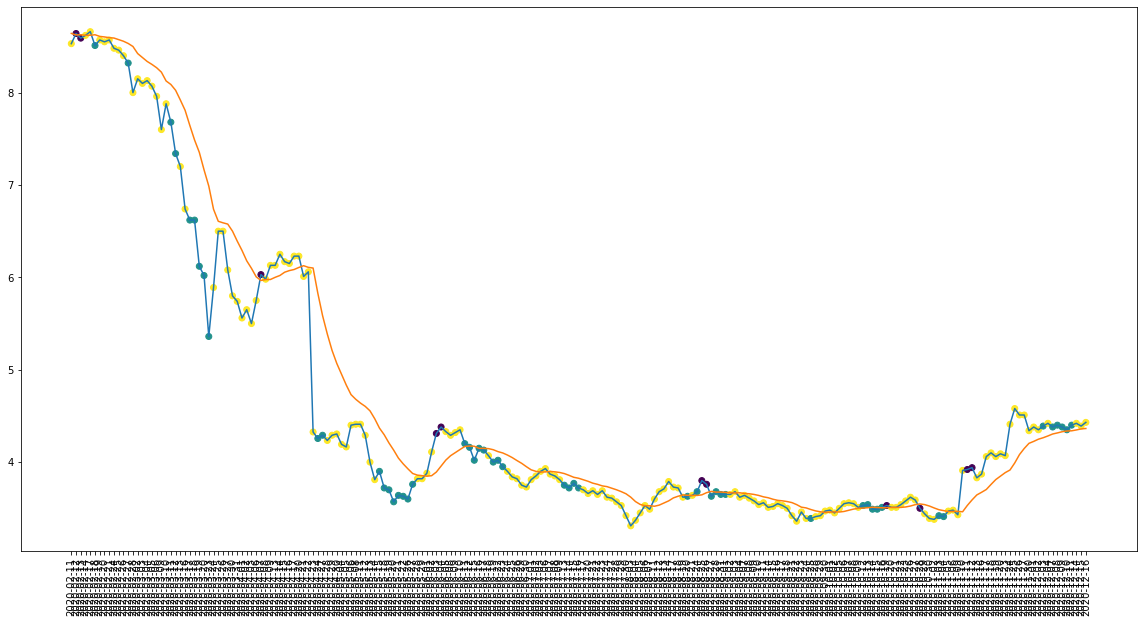

In [52]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [53]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 215
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 7
actual holds but predicted buy: 47
actual holds but predicted sell: 10
actual predicted holds: 141
Percentage buys correct: 37.5%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 71.21212121212122%
actual buys: 8
actual sells: 9
actual holds: 198


In [54]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[8.510000228881836, 8.529999732971191, 8.550000190734862, 8.569999694824219, 8.569999694824219, 8.590000152587889, 8.619999885559082, 8.640000343322754, 8.659999847412111]
[8.0, 8.149999618530272, 8.319999694824219, 8.399999618530272, 8.460000038146973, 8.479999542236326, 8.550000190734862, 8.569999694824219, 8.569999694824219]
Percentage buys correct: 54.90196078431372%
Percentage sells correct: 90.9090909090909%
Percentage holds correct: 84.9673202614379%


In [55]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $8.510000228881836
Shares owned at the moment: 1171
Cash capital at the moment: $7.385403742313429


Stop Loss Activated!

Share price: $8.0
Shares owned at the moment: 0
Cash capital at the moment: $9349.623403742313


Share price: $7.679999828338622
Shares owned at the moment: 1214
Cash capital at the moment: $0.46393271231681865


Stop Loss Activated!

Share price: $7.3400001525878915
Shares owned at the moment: 0
Cash capital at the moment: $8886.719527444602


Share price: $7.3400001525878915
Shares owned at the moment: 1207
Cash capital at the moment: $2.976047764539544


Stop Loss Activated!

Share price: $6.739999771118164
Shares owned at the moment: 0
Cash capital at the moment: $8115.78402726388


Share price: $6.619999885559082
Shares owned at the moment: 1222
Cash capital at the moment: $3.897657495259409


Stop Loss Activated!

Share price: $6.119999885559082
Shares owned at the moment: 0
Cash capital at the moment: $7461.971258033036


Share price: $6.1199998

In [56]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5165.4369528948055
profit gained: -48.34563047105195%


In [57]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.600917,33.333333333333336%,11.11111111111111%,63.5%,58.92857142857143%,57.142857142857146%,78.72340425531915%,-9.125151241259664%,-7.777238176262399%
1,0.674419,37.5%,11.11111111111111%,71.21212121212122%,54.90196078431372%,90.9090909090909%,84.9673202614379%,-27.68439793420087%,-48.34563047105195%


### OCBC Bank

In [58]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14      OBV_7  labels
0  2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
1  2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2  2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
3  2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
4  2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0


In [59]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,6.793788,7.018572,-90.000010,-1965914.0,2.0
2000-01-24,6.890842,6.998922,-77.777802,6276910.0,2.0
2000-01-25,6.793788,6.967363,-85.714286,-511055.0,2.0
2000-01-26,6.745261,6.933193,-86.666549,-7435027.0,2.0
2000-01-27,6.890842,6.926678,-66.666601,-3725757.0,2.0


In [60]:
df.drop(['OBV_7'], axis='columns', inplace=True)

In [61]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [62]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
X.shape

(4789, 15, 3)

In [63]:
y = labels
y = np.array(y)

In [64]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [65]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [66]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [67]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [68]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 39ms/step - loss: 0.2863 - accuracy: 0.4902 - mse: 0.4745 - weighted_accuracy: 0.3256 - weighted_mse: 0.5480 - val_loss: 0.3001 - val_accuracy: 0.0418 - val_mse: 0.3531 - val_weighted_accuracy: 0.0418 - val_weighted_mse: 0.3531
Epoch 2/200
30/30 [==============================] - 0s 11ms/step - loss: 0.2028 - accuracy: 0.2994 - mse: 0.8466 - weighted_accuracy: 0.4584 - weighted_mse: 0.8287 - val_loss: 0.2906 - val_accuracy: 0.0418 - val_mse: 0.3832 - val_weighted_accuracy: 0.0418 - val_weighted_mse: 0.3832
Epoch 3/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1866 - accuracy: 0.2793 - mse: 1.0782 - weighted_accuracy: 0.4823 - weighted_mse: 1.0483 - val_loss: 0.2803 - val_accuracy: 0.0418 - val_mse: 0.4207 - val_weighted_accuracy: 0.0418 - val_weighted_mse: 0.4207
Epoch 4/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1787 - accuracy: 0.2475 - mse: 1.2023 - weighted_accuracy: 0.4991 - weig

Epoch 30/200
30/30 [==============================] - 0s 12ms/step - loss: 0.1375 - accuracy: 0.3435 - mse: 1.7569 - weighted_accuracy: 0.6909 - weighted_mse: 1.6538 - val_loss: 0.1848 - val_accuracy: 0.3904 - val_mse: 1.6565 - val_weighted_accuracy: 0.3904 - val_weighted_mse: 1.6565
Epoch 31/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1372 - accuracy: 0.3889 - mse: 1.7666 - weighted_accuracy: 0.7001 - weighted_mse: 1.6824 - val_loss: 0.1906 - val_accuracy: 0.3455 - val_mse: 1.7604 - val_weighted_accuracy: 0.3455 - val_weighted_mse: 1.7604
Epoch 32/200
30/30 [==============================] - 0s 12ms/step - loss: 0.1371 - accuracy: 0.3866 - mse: 1.7480 - weighted_accuracy: 0.6933 - weighted_mse: 1.6470 - val_loss: 0.2095 - val_accuracy: 0.3121 - val_mse: 1.7245 - val_weighted_accuracy: 0.3121 - val_weighted_mse: 1.7245
Epoch 33/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1365 - accuracy: 0.3821 - mse: 1.7722 - weighted_accuracy: 0.7009 - 

Epoch 59/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1209 - accuracy: 0.4808 - mse: 2.1667 - weighted_accuracy: 0.7576 - weighted_mse: 2.0699 - val_loss: 0.1933 - val_accuracy: 0.4134 - val_mse: 2.3210 - val_weighted_accuracy: 0.4134 - val_weighted_mse: 2.3210
Epoch 60/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1211 - accuracy: 0.5098 - mse: 2.1914 - weighted_accuracy: 0.7520 - weighted_mse: 2.1219 - val_loss: 0.1872 - val_accuracy: 0.4353 - val_mse: 2.2653 - val_weighted_accuracy: 0.4353 - val_weighted_mse: 2.2653
Epoch 61/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1204 - accuracy: 0.4967 - mse: 2.1944 - weighted_accuracy: 0.7672 - weighted_mse: 2.1131 - val_loss: 0.2008 - val_accuracy: 0.3810 - val_mse: 2.2566 - val_weighted_accuracy: 0.3810 - val_weighted_mse: 2.2566
Epoch 62/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1194 - accuracy: 0.5027 - mse: 2.1876 - weighted_accuracy: 0.7622 - 

Epoch 88/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1042 - accuracy: 0.5923 - mse: 2.6642 - weighted_accuracy: 0.8229 - weighted_mse: 2.5911 - val_loss: 0.1696 - val_accuracy: 0.5459 - val_mse: 2.6805 - val_weighted_accuracy: 0.5459 - val_weighted_mse: 2.6805
Epoch 89/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1037 - accuracy: 0.6072 - mse: 2.6706 - weighted_accuracy: 0.8282 - weighted_mse: 2.5859 - val_loss: 0.1806 - val_accuracy: 0.4958 - val_mse: 2.6855 - val_weighted_accuracy: 0.4958 - val_weighted_mse: 2.6855
Epoch 90/200
30/30 [==============================] - 0s 12ms/step - loss: 0.1028 - accuracy: 0.6108 - mse: 2.6708 - weighted_accuracy: 0.8180 - weighted_mse: 2.5913 - val_loss: 0.1748 - val_accuracy: 0.5365 - val_mse: 2.8033 - val_weighted_accuracy: 0.5365 - val_weighted_mse: 2.8033
Epoch 91/200
30/30 [==============================] - 0s 12ms/step - loss: 0.1034 - accuracy: 0.6032 - mse: 2.7243 - weighted_accuracy: 0.8250 - 

Epoch 117/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0884 - accuracy: 0.6943 - mse: 3.3491 - weighted_accuracy: 0.8579 - weighted_mse: 3.2157 - val_loss: 0.1719 - val_accuracy: 0.5647 - val_mse: 3.5499 - val_weighted_accuracy: 0.5647 - val_weighted_mse: 3.5499
Epoch 118/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0874 - accuracy: 0.6904 - mse: 3.3594 - weighted_accuracy: 0.8700 - weighted_mse: 3.2471 - val_loss: 0.1699 - val_accuracy: 0.5804 - val_mse: 3.5047 - val_weighted_accuracy: 0.5804 - val_weighted_mse: 3.5047
Epoch 119/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0862 - accuracy: 0.6763 - mse: 3.3711 - weighted_accuracy: 0.8666 - weighted_mse: 3.2538 - val_loss: 0.1428 - val_accuracy: 0.6837 - val_mse: 3.6297 - val_weighted_accuracy: 0.6837 - val_weighted_mse: 3.6297
Epoch 120/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0859 - accuracy: 0.7142 - mse: 3.4375 - weighted_accuracy: 0.8653 - 

Epoch 146/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0748 - accuracy: 0.7539 - mse: 4.3421 - weighted_accuracy: 0.8969 - weighted_mse: 4.1053 - val_loss: 0.1633 - val_accuracy: 0.6524 - val_mse: 4.3854 - val_weighted_accuracy: 0.6524 - val_weighted_mse: 4.3854
Epoch 147/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0748 - accuracy: 0.7434 - mse: 4.3094 - weighted_accuracy: 0.8856 - weighted_mse: 4.1121 - val_loss: 0.1673 - val_accuracy: 0.6493 - val_mse: 4.4496 - val_weighted_accuracy: 0.6493 - val_weighted_mse: 4.4496
Epoch 148/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0754 - accuracy: 0.7450 - mse: 4.3953 - weighted_accuracy: 0.8899 - weighted_mse: 4.1382 - val_loss: 0.1554 - val_accuracy: 0.6795 - val_mse: 4.6415 - val_weighted_accuracy: 0.6795 - val_weighted_mse: 4.6415
Epoch 149/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0729 - accuracy: 0.7473 - mse: 4.4246 - weighted_accuracy: 0.8927 - 

Epoch 175/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0640 - accuracy: 0.7961 - mse: 5.4962 - weighted_accuracy: 0.9142 - weighted_mse: 5.1542 - val_loss: 0.1655 - val_accuracy: 0.7088 - val_mse: 5.9019 - val_weighted_accuracy: 0.7088 - val_weighted_mse: 5.9019
Epoch 176/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0628 - accuracy: 0.7904 - mse: 5.5681 - weighted_accuracy: 0.9081 - weighted_mse: 5.2085 - val_loss: 0.1440 - val_accuracy: 0.7808 - val_mse: 6.1219 - val_weighted_accuracy: 0.7808 - val_weighted_mse: 6.1219
Epoch 177/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0618 - accuracy: 0.8074 - mse: 5.5637 - weighted_accuracy: 0.9165 - weighted_mse: 5.1940 - val_loss: 0.1596 - val_accuracy: 0.7286 - val_mse: 6.1065 - val_weighted_accuracy: 0.7286 - val_weighted_mse: 6.1065
Epoch 178/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0605 - accuracy: 0.8108 - mse: 5.6412 - weighted_accuracy: 0.9231 - 

In [69]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

Test loss: 0.164058119058609
Test accuracy: 0.7306889295578003


In [70]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-3.633698   -4.6148553   2.2304769 ]
 [-3.9008899  -1.4787728   0.48512432]
 [-2.5615098  -4.4151254   1.7250482 ]
 ...
 [-1.0164921  -2.8989017   0.6116084 ]
 [-0.20894293 -2.6948462  -0.5623483 ]
 [-0.78178495 -4.9390483   0.11085849]]


Counter({2: 752, 0: 120, 1: 86})

In [71]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 874, 1: 40, 0: 44})

In [72]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 958
actual predicted buys: 9
actual buys but predicted sell: 1
actual buys but predicted hold: 30
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 37
actual holds but predicted buy: 76
actual holds but predicted sell: 113
actual predicted holds: 685
Percentage buys correct: 22.5%
Percentage sells correct: 13.636363636363637%
Percentage holds correct: 78.37528604118994%
actual buys: 40
actual sells: 44
actual holds: 874


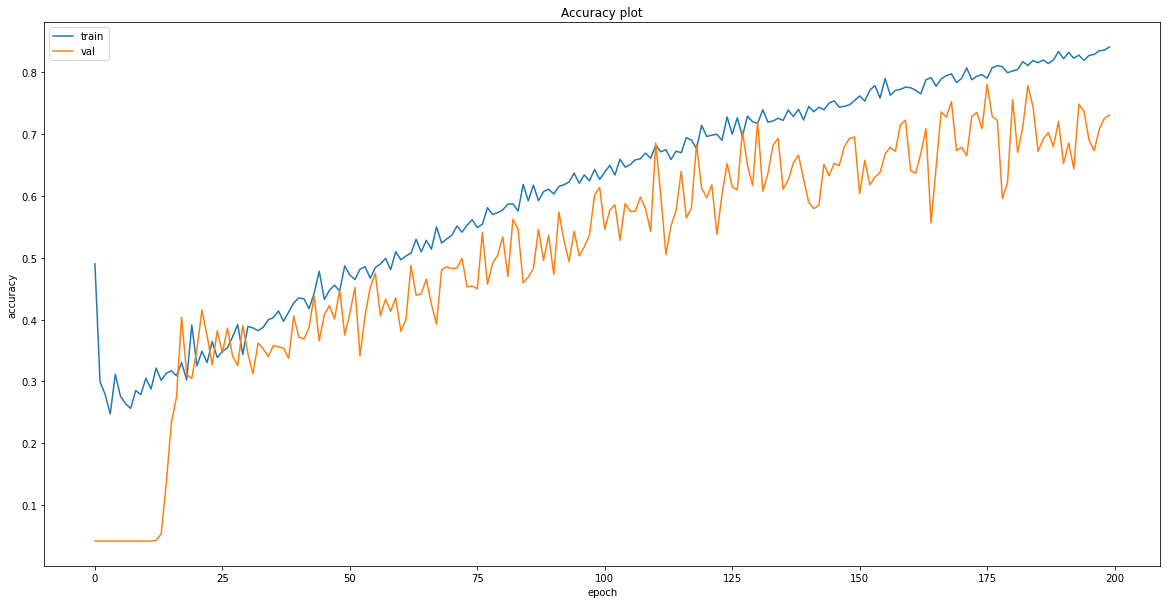

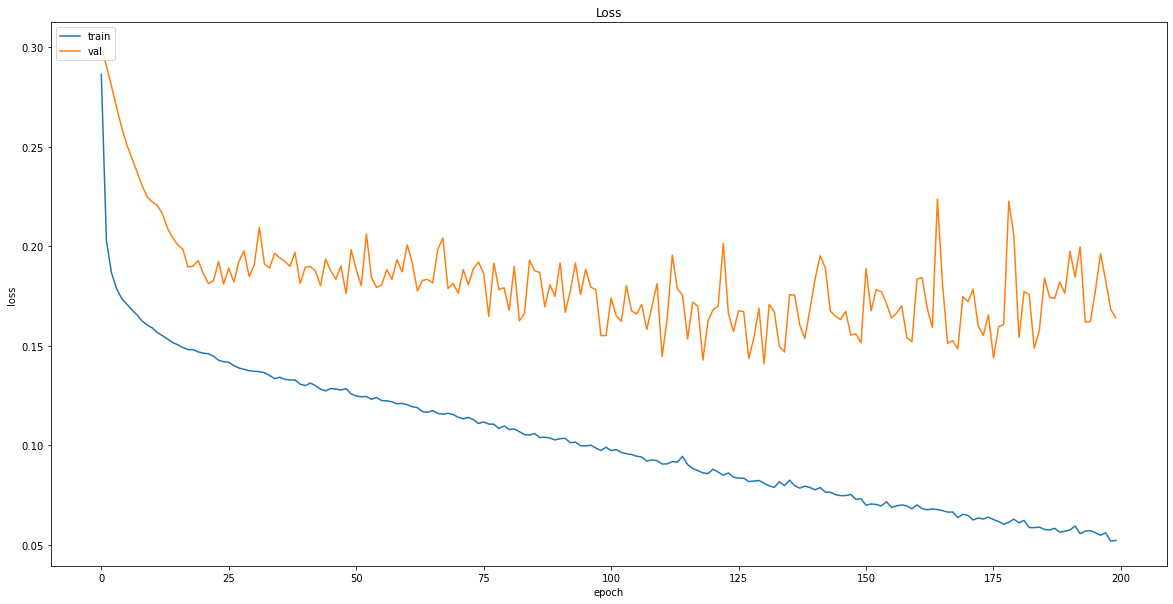

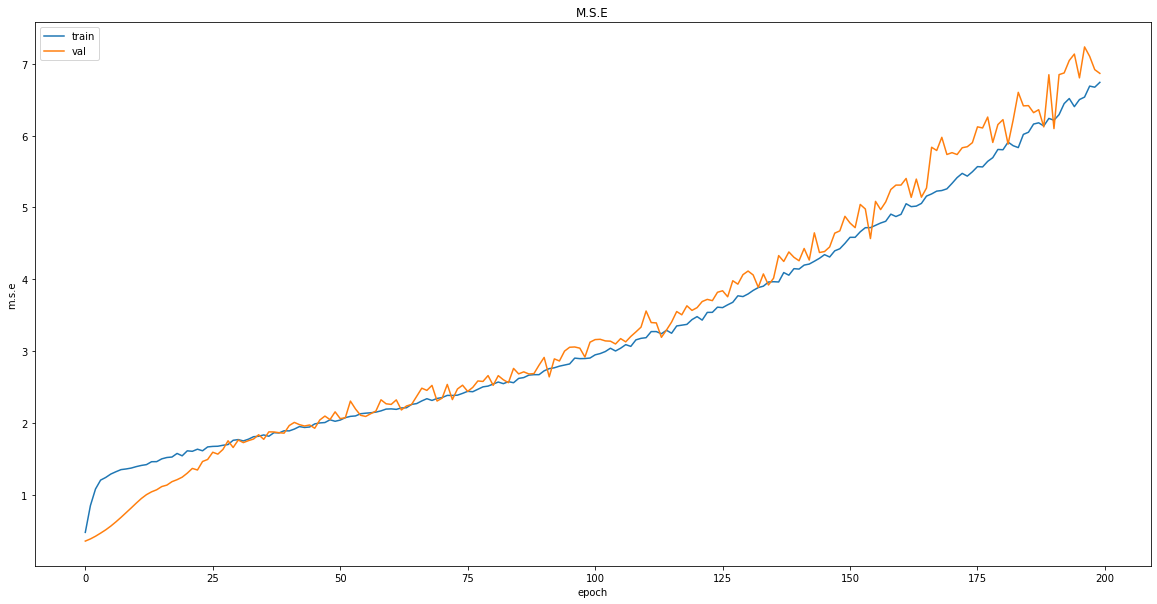

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('M.S.E')
plt.ylabel('m.s.e')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [74]:
# Save model
model.save("models/{}".format('ocbc_time_series_lstm_buy_hold_sell_no_obv.model'))

INFO:tensorflow:Assets written to: models/ocbc_time_series_lstm_buy_hold_sell_no_obv.model\assets


### Test Performance

### non-recession

In [75]:
logger = []

In [76]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-21        11.75  11.523654 -10.869606  21160951.0     2.0
2019-01-22        11.73  11.555399 -13.978517  18040951.0     2.0
2019-01-23        11.50  11.546876 -38.709667  14286851.0     1.0
2019-01-24        11.38  11.521203 -51.612890   8454651.0     2.0
2019-01-25        11.41  11.504095 -80.357185  12469051.0     2.0


In [77]:
df.drop(['OBV_7'], axis='columns', inplace=True)

In [78]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [79]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(218, 15, 3)

In [80]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [81]:
model = tf.keras.models.load_model("models/ocbc_time_series_lstm_buy_hold_sell_no_obv.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1747 - accuracy: 0.7615 - mean_squared_error: 8.3233 - weighted_accuracy: 0.7615 - weighted_mean_squared_error: 8.3233
Test loss: 0.1746741682291031
Test accuracy: 0.7614678740501404


In [82]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 174, 0: 15, 1: 29})

In [83]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 201, 0: 9, 1: 8})

In [84]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test.csv")
df.set_index('Date', inplace=True)

In [85]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,11.53,11.457507,-67.857228,17615658.0,2.0,2,2
2019-02-12,11.49,11.468659,-43.902530,20832858.0,2.0,2,2
2019-02-13,11.65,11.471942,-42.424356,17325458.0,2.0,2,2
2019-02-14,11.68,11.499336,-10.256417,22091358.0,2.0,2,2
2019-02-15,11.52,11.527130,-5.714153,24228358.0,2.0,2,2


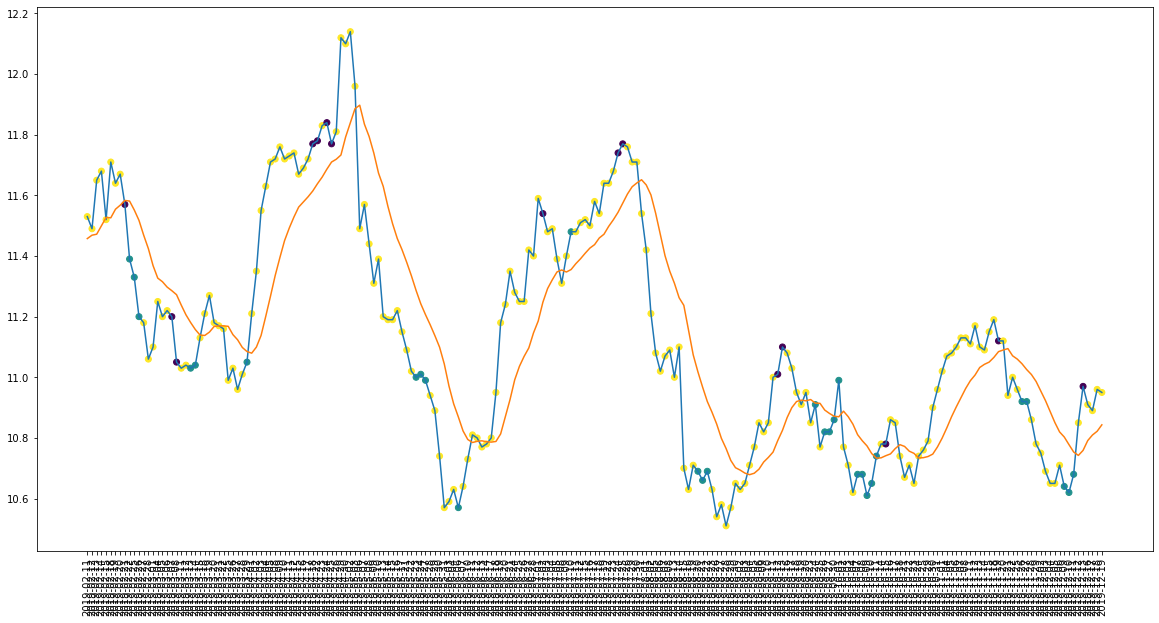

In [86]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

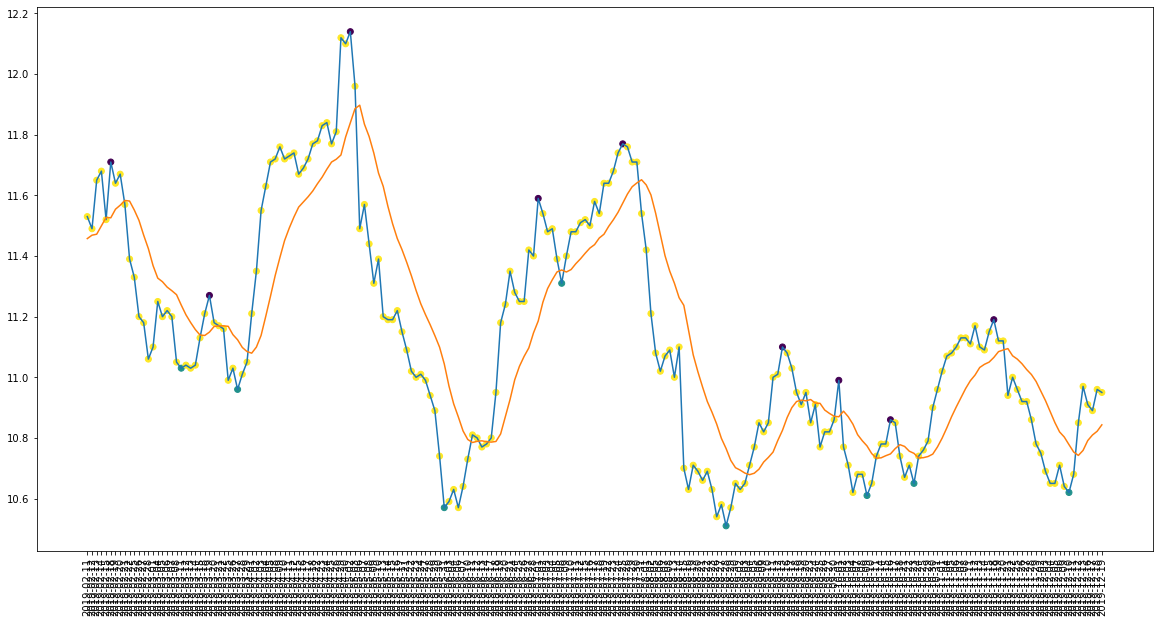

In [87]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [88]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 6
actual holds but predicted buy: 26
actual holds but predicted sell: 13
actual predicted holds: 162
Percentage buys correct: 25.0%
Percentage sells correct: 22.22222222222222%
Percentage holds correct: 80.59701492537313%
actual buys: 8
actual sells: 9
actual holds: 201


In [89]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[11.489999771118164, 11.520000457763672, 11.529999732971193, 11.56999969482422, 11.640000343322756, 11.649999618530273, 11.670000076293945, 11.68000030517578, 11.710000038146973]
[11.0600004196167, 11.100000381469727, 11.18000030517578, 11.199999809265137, 11.329999923706055, 11.390000343322756, 11.56999969482422, 11.640000343322756, 11.670000076293945]
Percentage buys correct: 55.172413793103445%
Percentage sells correct: 86.66666666666667%
Percentage holds correct: 87.86127167630057%


In [90]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $11.390000343322756
Shares owned at the moment: 875
Cash capital at the moment: $6.3425112664681365


Stop Loss Activated!

Share price: $11.0600004196167
Shares owned at the moment: 0
Cash capital at the moment: $9657.229752421377


Share price: $11.029999732971193
Shares owned at the moment: 873
Cash capital at the moment: $1.5597136785945622


Price increase from previously bought: 6.416337327177035%
Share price: $11.770000457763672
Shares owned at the moment: 0
Cash capital at the moment: $10248.513284707304


Share price: $11.0
Shares owned at the moment: 929
Cash capital at the moment: $1.4110347073037701


Stop Loss Activated!

Share price: $10.56999969482422
Shares owned at the moment: 0
Cash capital at the moment: $9793.937044478653


Share price: $10.56999969482422
Shares owned at the moment: 924
Cash capital at the moment: $0.3989572365244385


Price increase from previously bought: 8.877505450687417%
Share price: $11.539999961853027
Shares owned at the moment: 

In [91]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9445.467587005614
profit gained: -5.545324129943856%


In [92]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.600917,33.333333333333336%,11.11111111111111%,63.5%,58.92857142857143%,57.142857142857146%,78.72340425531915%,-9.125151241259664%,-7.777238176262399%
1,0.674419,37.5%,11.11111111111111%,71.21212121212122%,54.90196078431372%,90.9090909090909%,84.9673202614379%,-27.68439793420087%,-48.34563047105195%
2,0.761468,25.0%,22.22222222222222%,80.59701492537313%,55.172413793103445%,86.66666666666667%,87.86127167630057%,3.9843991503118925%,-5.545324129943856%


### recession

In [93]:
logger = []

In [94]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22        11.12  11.072811 -24.444379  27489400.0     2.0
2020-01-23        11.19  11.090840  -8.888884  31751200.0     2.0
2020-01-24        11.11  11.093787 -26.666653  27359800.0     2.0
2020-01-28        11.10  11.094743 -28.888715  24699300.0     2.0
2020-01-29        10.90  11.064783 -71.739257  16499235.0     2.0


In [95]:
df.drop(['OBV_7'], axis='columns', inplace=True)

In [96]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [97]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(215, 15, 3)

In [98]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [99]:
model = tf.keras.models.load_model("models/ocbc_time_series_lstm_buy_hold_sell_no_obv.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1460 - accuracy: 0.8000 - mean_squared_error: 7.1386 - weighted_accuracy: 0.8000 - weighted_mean_squared_error: 7.1386
Test loss: 0.1459524780511856
Test accuracy: 0.800000011920929


In [100]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 186, 1: 12, 0: 17})

In [101]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 193, 0: 10, 1: 12})

In [102]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test2.csv")
df.set_index('Date', inplace=True)

In [103]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-12,11.02,10.890637,-80.357049,13333200.0,2.0,2,2
2020-02-13,11.05,10.910539,-32.075322,21593100.0,2.0,2,2
2020-02-14,11.06,10.931995,-15.217324,25962500.0,2.0,2,2
2020-02-17,11.01,10.951688,-13.043361,29610200.0,2.0,2,2
2020-02-18,10.97,10.960659,-23.912967,27996300.0,2.0,2,2


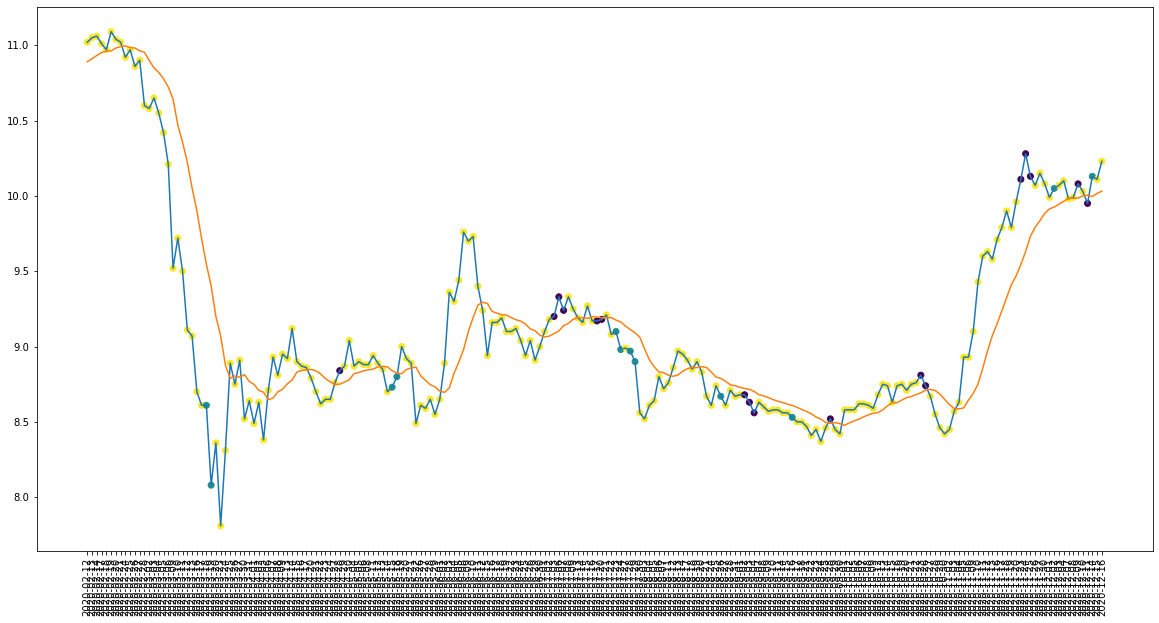

In [104]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

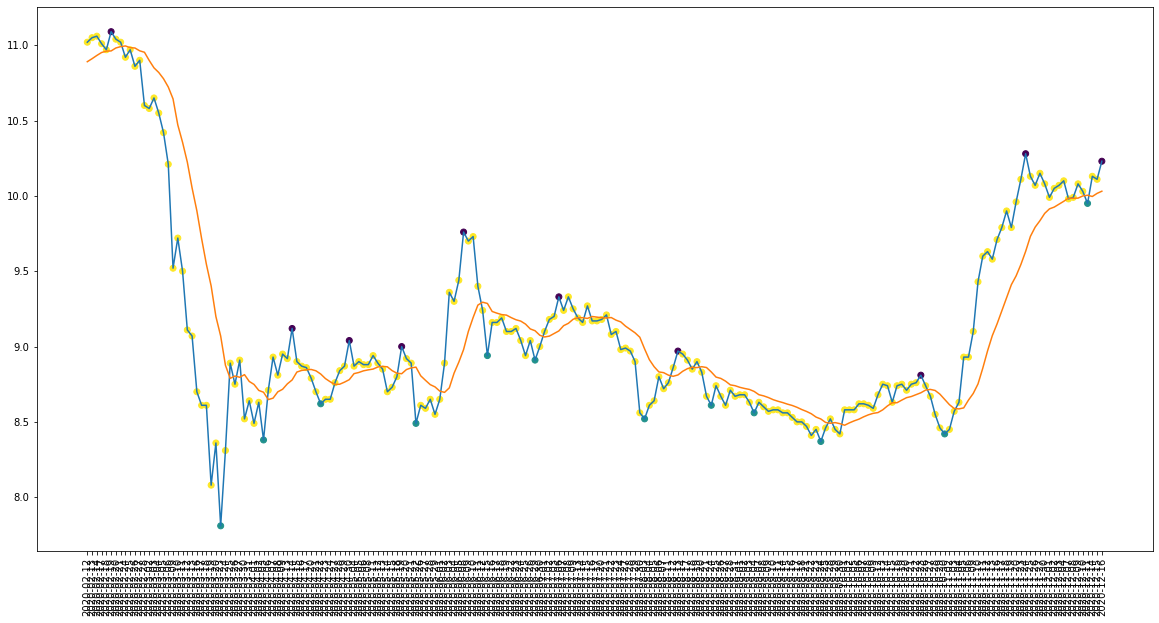

In [105]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [106]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 215
actual predicted buys: 0
actual buys but predicted sell: 2
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 12
actual holds but predicted sell: 12
actual predicted holds: 169
Percentage buys correct: 0.0%
Percentage sells correct: 30.0%
Percentage holds correct: 87.56476683937824%
actual buys: 12
actual sells: 10
actual holds: 193


In [107]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[10.920000076293944, 10.970000267028807, 11.010000228881836, 11.020000457763672, 11.020000457763672, 11.039999961853027, 11.050000190734863, 11.0600004196167, 11.09000015258789]
[10.579999923706056, 10.600000381469727, 10.649999618530273, 10.859999656677246, 10.899999618530273, 10.920000076293944, 10.970000267028807, 11.020000457763672, 11.039999961853027]
Percentage buys correct: 50.0%
Percentage sells correct: 64.70588235294117%
Percentage holds correct: 86.48648648648648%


In [108]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $8.609999656677246
Shares owned at the moment: 1158
Cash capital at the moment: $2.201853661059431


Stop Loss Activated!

Share price: $8.079999923706055
Shares owned at the moment: 0
Cash capital at the moment: $9333.11100555563


Share price: $8.079999923706055
Shares owned at the moment: 1151
Cash capital at the moment: $7.455873611448624


Stop Loss Activated!

Share price: $7.809999942779541
Shares owned at the moment: 0
Cash capital at the moment: $8972.045205431818


Share price: $8.729999542236326
Shares owned at the moment: 1024
Cash capital at the moment: $7.941995470881011


Stop Loss Activated!

Share price: $8.489999771118164
Shares owned at the moment: 0
Cash capital at the moment: $8677.793921740413


Share price: $9.100000381469727
Shares owned at the moment: 950
Cash capital at the moment: $9.019808347582511


Stop Loss Activated!

Share price: $8.560000419616701
Shares owned at the moment: 0
Cash capital at the moment: $8118.6572058872


Share price: $8.

In [109]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9233.011672363282
profit gained: -7.669883276367181%


In [110]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.600917,33.333333333333336%,11.11111111111111%,63.5%,58.92857142857143%,57.142857142857146%,78.72340425531915%,-9.125151241259664%,-7.777238176262399%
1,0.674419,37.5%,11.11111111111111%,71.21212121212122%,54.90196078431372%,90.9090909090909%,84.9673202614379%,-27.68439793420087%,-48.34563047105195%
2,0.761468,25.0%,22.22222222222222%,80.59701492537313%,55.172413793103445%,86.66666666666667%,87.86127167630057%,3.9843991503118925%,-5.545324129943856%
3,0.800000,0.0%,30.0%,87.56476683937824%,50.0%,64.70588235294117%,86.48648648648648%,-20.71219810776589%,-7.669883276367181%


## CNOOC Limited

In [111]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14       OBV_7  labels
0  2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
1  2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2  2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
3  2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
4  2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0


In [112]:
df.drop(['OBV_7'], axis='columns', inplace=True)

In [113]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,labels
Date,,,,
2004-04-07,3.250,3.264699,-57.142857,2.0
2004-04-08,3.200,3.254745,-78.947368,2.0
2004-04-13,3.250,3.254015,-52.631579,0.0
2004-04-14,3.375,3.272628,-10.416706,2.0
2004-04-15,3.275,3.272993,-52.083331,2.0


In [114]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [115]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
X.shape

(3590, 15, 3)

In [116]:
y = labels
y = np.array(y)

In [117]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [118]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [119]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [120]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [121]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
23/23 [==============================] - 1s 38ms/step - loss: 0.2987 - accuracy: 0.5446 - mse: 0.4248 - weighted_accuracy: 0.3455 - weighted_mse: 0.5162 - val_loss: 0.3017 - val_accuracy: 0.0418 - val_mse: 0.3471 - val_weighted_accuracy: 0.0418 - val_weighted_mse: 0.3471
Epoch 2/200
23/23 [==============================] - 0s 8ms/step - loss: 0.2149 - accuracy: 0.3736 - mse: 0.7315 - weighted_accuracy: 0.4346 - weighted_mse: 0.7351 - val_loss: 0.2947 - val_accuracy: 0.0446 - val_mse: 0.3667 - val_weighted_accuracy: 0.0446 - val_weighted_mse: 0.3667
Epoch 3/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1912 - accuracy: 0.2601 - mse: 0.9652 - weighted_accuracy: 0.4942 - weighted_mse: 0.9307 - val_loss: 0.2868 - val_accuracy: 0.0446 - val_mse: 0.3921 - val_weighted_accuracy: 0.0446 - val_weighted_mse: 0.3921
Epoch 4/200
23/23 [==============================] - 0s 8ms/step - loss: 0.1821 - accuracy: 0.2803 - mse: 1.0872 - weighted_accuracy: 0.5089 - weighte

23/23 [==============================] - 0s 7ms/step - loss: 0.1399 - accuracy: 0.3269 - mse: 1.6398 - weighted_accuracy: 0.6735 - weighted_mse: 1.5484 - val_loss: 0.1701 - val_accuracy: 0.4610 - val_mse: 1.4482 - val_weighted_accuracy: 0.4610 - val_weighted_mse: 1.4482
Epoch 30/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1404 - accuracy: 0.3618 - mse: 1.6390 - weighted_accuracy: 0.6669 - weighted_mse: 1.5567 - val_loss: 0.1703 - val_accuracy: 0.4582 - val_mse: 1.4670 - val_weighted_accuracy: 0.4582 - val_weighted_mse: 1.4670
Epoch 31/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1393 - accuracy: 0.3736 - mse: 1.6484 - weighted_accuracy: 0.6858 - weighted_mse: 1.5709 - val_loss: 0.1757 - val_accuracy: 0.4318 - val_mse: 1.4397 - val_weighted_accuracy: 0.4318 - val_weighted_mse: 1.4397
Epoch 32/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1384 - accuracy: 0.3907 - mse: 1.6815 - weighted_accuracy: 0.6727 - weighted_mse: 1.6

Epoch 58/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1228 - accuracy: 0.5139 - mse: 2.0271 - weighted_accuracy: 0.7517 - weighted_mse: 2.0148 - val_loss: 0.1914 - val_accuracy: 0.4304 - val_mse: 2.0813 - val_weighted_accuracy: 0.4304 - val_weighted_mse: 2.0813
Epoch 59/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1214 - accuracy: 0.4641 - mse: 2.0548 - weighted_accuracy: 0.7384 - weighted_mse: 2.0191 - val_loss: 0.1838 - val_accuracy: 0.4499 - val_mse: 1.9875 - val_weighted_accuracy: 0.4499 - val_weighted_mse: 1.9875
Epoch 60/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1207 - accuracy: 0.5150 - mse: 2.0399 - weighted_accuracy: 0.7666 - weighted_mse: 2.0274 - val_loss: 0.1826 - val_accuracy: 0.4499 - val_mse: 1.9792 - val_weighted_accuracy: 0.4499 - val_weighted_mse: 1.9792
Epoch 61/200
23/23 [==============================] - 0s 6ms/step - loss: 0.1213 - accuracy: 0.4843 - mse: 2.0884 - weighted_accuracy: 0.7675 - weig

Epoch 87/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1073 - accuracy: 0.5930 - mse: 2.4340 - weighted_accuracy: 0.8194 - weighted_mse: 2.4521 - val_loss: 0.1741 - val_accuracy: 0.5209 - val_mse: 2.5345 - val_weighted_accuracy: 0.5209 - val_weighted_mse: 2.5345
Epoch 88/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1064 - accuracy: 0.5930 - mse: 2.4488 - weighted_accuracy: 0.8266 - weighted_mse: 2.4781 - val_loss: 0.1698 - val_accuracy: 0.5209 - val_mse: 2.5161 - val_weighted_accuracy: 0.5209 - val_weighted_mse: 2.5161
Epoch 89/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1056 - accuracy: 0.5968 - mse: 2.4743 - weighted_accuracy: 0.8305 - weighted_mse: 2.5104 - val_loss: 0.1706 - val_accuracy: 0.5348 - val_mse: 2.5262 - val_weighted_accuracy: 0.5348 - val_weighted_mse: 2.5262
Epoch 90/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1045 - accuracy: 0.6177 - mse: 2.4877 - weighted_accuracy: 0.8285 - weig

Epoch 116/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0928 - accuracy: 0.6807 - mse: 2.9815 - weighted_accuracy: 0.8613 - weighted_mse: 3.0409 - val_loss: 0.1807 - val_accuracy: 0.5515 - val_mse: 3.0147 - val_weighted_accuracy: 0.5515 - val_weighted_mse: 3.0147
Epoch 117/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0904 - accuracy: 0.6570 - mse: 3.0048 - weighted_accuracy: 0.8525 - weighted_mse: 3.0639 - val_loss: 0.1538 - val_accuracy: 0.6323 - val_mse: 2.9942 - val_weighted_accuracy: 0.6323 - val_weighted_mse: 2.9942
Epoch 118/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0914 - accuracy: 0.6985 - mse: 3.0248 - weighted_accuracy: 0.8701 - weighted_mse: 3.0661 - val_loss: 0.1827 - val_accuracy: 0.5306 - val_mse: 3.0719 - val_weighted_accuracy: 0.5306 - val_weighted_mse: 3.0719
Epoch 119/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0906 - accuracy: 0.6804 - mse: 3.0570 - weighted_accuracy: 0.8683 - 

Epoch 145/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0781 - accuracy: 0.7448 - mse: 3.7365 - weighted_accuracy: 0.8992 - weighted_mse: 3.7967 - val_loss: 0.1857 - val_accuracy: 0.5780 - val_mse: 3.9126 - val_weighted_accuracy: 0.5780 - val_weighted_mse: 3.9126
Epoch 146/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0763 - accuracy: 0.7403 - mse: 3.7314 - weighted_accuracy: 0.8951 - weighted_mse: 3.7979 - val_loss: 0.1654 - val_accuracy: 0.6462 - val_mse: 4.0085 - val_weighted_accuracy: 0.6462 - val_weighted_mse: 4.0085
Epoch 147/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0778 - accuracy: 0.7517 - mse: 3.8354 - weighted_accuracy: 0.8921 - weighted_mse: 3.8901 - val_loss: 0.1803 - val_accuracy: 0.5947 - val_mse: 3.9208 - val_weighted_accuracy: 0.5947 - val_weighted_mse: 3.9208
Epoch 148/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0764 - accuracy: 0.7636 - mse: 3.7904 - weighted_accuracy: 0.8941 - 

Epoch 174/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0666 - accuracy: 0.8085 - mse: 4.6871 - weighted_accuracy: 0.9201 - weighted_mse: 4.7078 - val_loss: 0.1638 - val_accuracy: 0.6741 - val_mse: 4.8416 - val_weighted_accuracy: 0.6741 - val_weighted_mse: 4.8416
Epoch 175/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0704 - accuracy: 0.7597 - mse: 4.6252 - weighted_accuracy: 0.8975 - weighted_mse: 4.6233 - val_loss: 0.1778 - val_accuracy: 0.6657 - val_mse: 4.6759 - val_weighted_accuracy: 0.6657 - val_weighted_mse: 4.6759
Epoch 176/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0648 - accuracy: 0.7918 - mse: 4.6592 - weighted_accuracy: 0.9164 - weighted_mse: 4.6774 - val_loss: 0.1591 - val_accuracy: 0.6992 - val_mse: 5.0097 - val_weighted_accuracy: 0.6992 - val_weighted_mse: 5.0097
Epoch 177/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0640 - accuracy: 0.8012 - mse: 4.7499 - weighted_accuracy: 0.9198 - 

In [122]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

Test loss: 0.16382108628749847
Test accuracy: 0.7270194888114929


In [123]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.16060871 -4.3817086  -0.6302199 ]
 [-2.3584344  -1.7177557   0.51016974]
 [-4.1900268  -3.4495356   2.3240705 ]
 ...
 [-5.0529704  -1.1562178   0.26561332]
 [-1.5240668  -4.8763256   1.3097628 ]
 [-2.2781968  -2.148433    0.9629975 ]]


Counter({0: 84, 2: 558, 1: 76})

In [124]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 653, 0: 33, 1: 32})

In [125]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 718
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 23
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 27
actual holds but predicted buy: 66
actual holds but predicted sell: 79
actual predicted holds: 508
Percentage buys correct: 28.125%
Percentage sells correct: 15.151515151515152%
Percentage holds correct: 77.7947932618683%
actual buys: 32
actual sells: 33
actual holds: 653


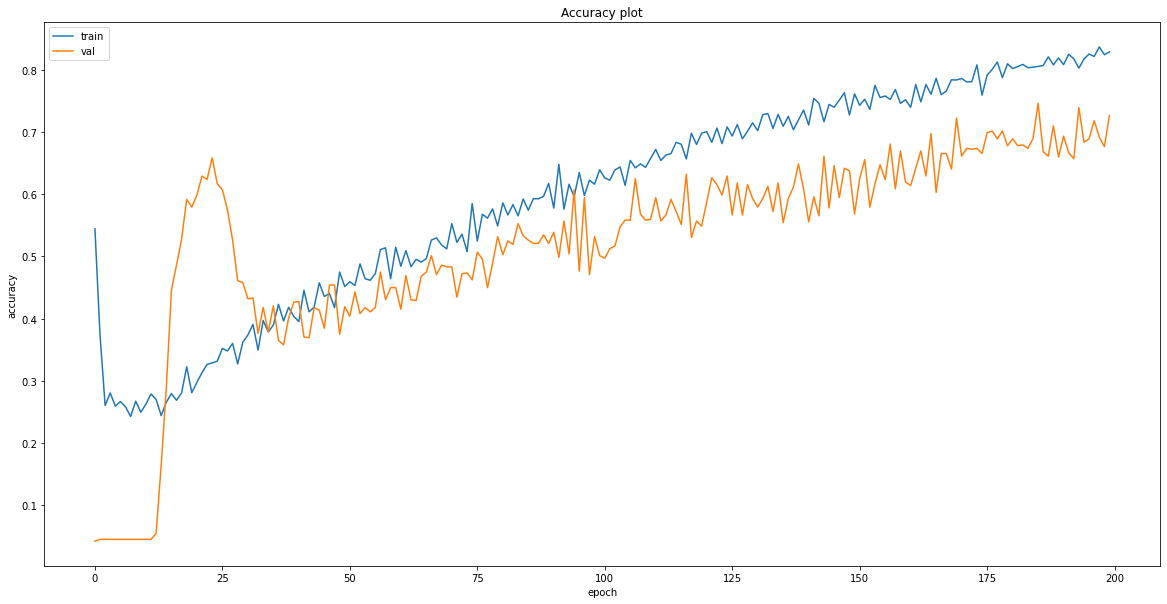

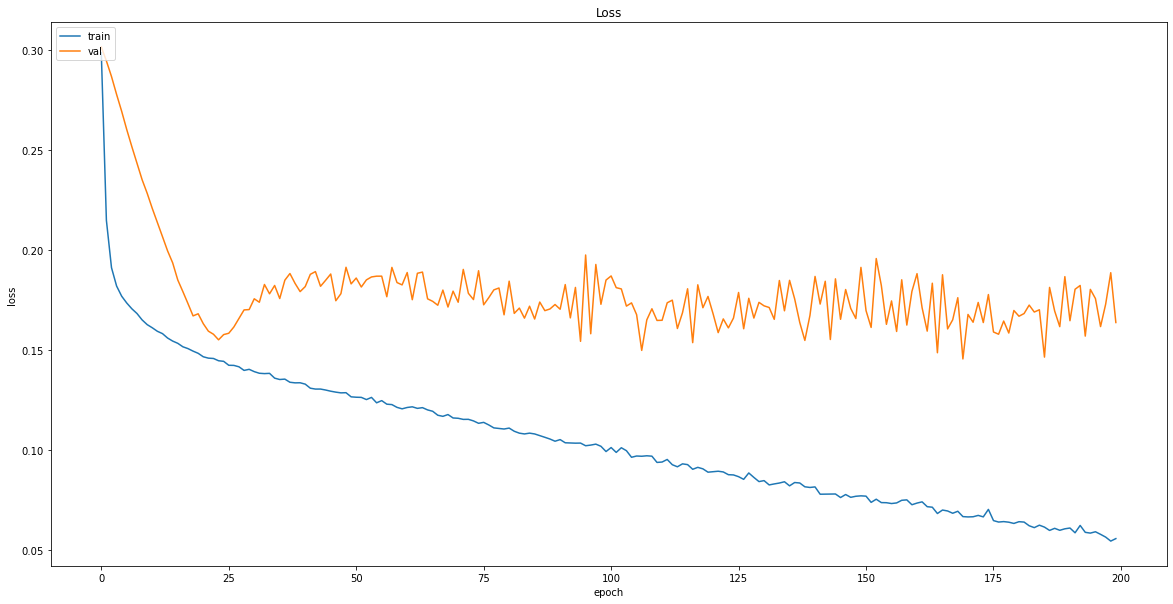

In [126]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [127]:
# Save model
model.save("models/{}".format('cnooc_time_series_lstm_buy_hold_sell_no_obv.model'))

INFO:tensorflow:Assets written to: models/cnooc_time_series_lstm_buy_hold_sell_no_obv.model\assets


### Test Performance

### non-recession

In [128]:
logger = []

In [129]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-01-22        13.12  12.552209  -3.030323  489168111.0     2.0
2019-01-23        12.94  12.611869 -13.043517  449876554.0     2.0
2019-01-24        12.62  12.613120 -33.333352  395082483.0     2.0
2019-01-25        12.80  12.641871 -37.254896  441807090.0     2.0
2019-01-28        13.06  12.706198 -11.764689  494043477.0     2.0


In [130]:
df.drop(['OBV_7'], axis='columns', inplace=True)

In [131]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(211, 15, 3)

In [132]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [133]:
model = tf.keras.models.load_model("models/cnooc_time_series_lstm_buy_hold_sell_no_obv.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 4ms/step - loss: 0.1859 - accuracy: 0.6872 - mean_squared_error: 5.4059 - weighted_accuracy: 0.6872 - weighted_mean_squared_error: 5.4059
Test loss: 0.18587720394134521
Test accuracy: 0.6872037649154663


In [134]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 155, 0: 30, 1: 26})

In [135]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [136]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test.csv")
df.set_index('Date', inplace=True)

In [137]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-14,13.46,13.005887,-9.090899,594167146.0,2.0,2,2
2019-02-15,13.28,13.075751,-2.222168,636062191.0,2.0,2,2
2019-02-18,13.68,13.107174,-22.222210,601994876.0,2.0,2,2
2019-02-19,13.76,13.195301,-15.384598,654106730.0,2.0,0,2
2019-02-20,13.92,13.282178,-9.230759,687559434.0,2.0,2,2


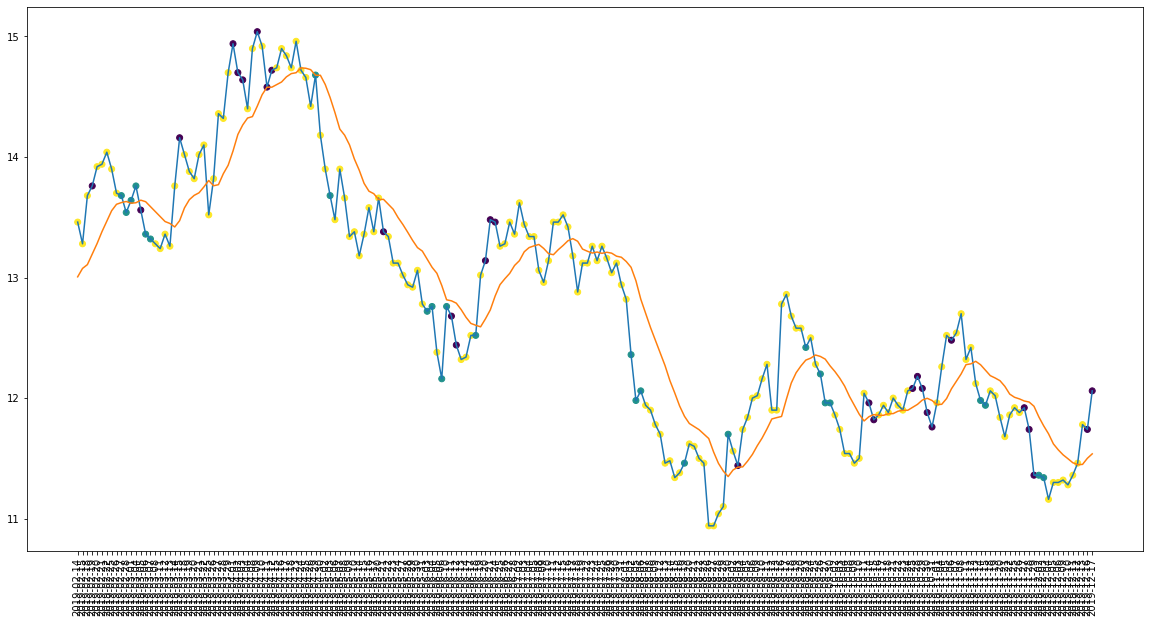

In [138]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

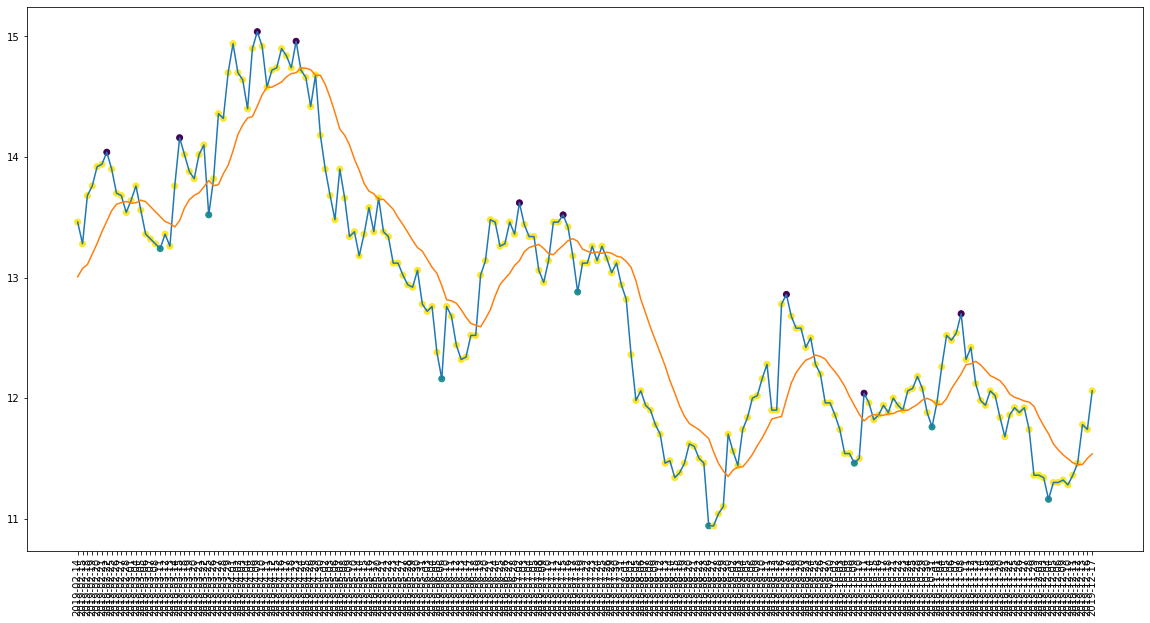

In [139]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [140]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 211
actual predicted buys: 1
actual buys but predicted sell: 1
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 7
actual holds but predicted buy: 25
actual holds but predicted sell: 27
actual predicted holds: 142
Percentage buys correct: 12.5%
Percentage sells correct: 22.22222222222222%
Percentage holds correct: 73.19587628865979%
actual buys: 8
actual sells: 9
actual holds: 194


In [141]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[13.279999732971193, 13.460000038146973, 13.68000030517578, 13.699999809265135, 13.760000228881836, 13.899999618530273, 13.920000076293945, 13.9399995803833, 14.039999961853027]
[13.359999656677244, 13.539999961853027, 13.5600004196167, 13.640000343322756, 13.68000030517578, 13.699999809265135, 13.760000228881836, 13.899999618530273, 14.039999961853027]
Percentage buys correct: 53.84615384615385%
Percentage sells correct: 58.62068965517241%
Percentage holds correct: 83.2258064516129%


In [142]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $13.68000030517578
Shares owned at the moment: 728
Cash capital at the moment: $13.572417221070282


Stop Loss Activated!

Share price: $13.279999732971193
Shares owned at the moment: 0
Cash capital at the moment: $9654.825663358692


Share price: $14.68000030517578
Shares owned at the moment: 655
Cash capital at the moment: $12.983112918858751


Stop Loss Activated!

Share price: $14.18000030517578
Shares owned at the moment: 0
Cash capital at the moment: $9275.341587259296


Share price: $13.68000030517578
Shares owned at the moment: 676
Cash capital at the moment: $2.230260393147546


Stop Loss Activated!

Share price: $13.18000030517578
Shares owned at the moment: 0
Cash capital at the moment: $8887.408846124652


Share price: $12.720000267028807
Shares owned at the moment: 696
Cash capital at the moment: $9.942579761509478


Stop Loss Activated!

Share price: $12.15999984741211
Shares owned at the moment: 0
Cash capital at the moment: $8450.02823385239


Share price: 

In [143]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $8912.067081356048
profit gained: -10.879329186439518%


In [144]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.600917,33.333333333333336%,11.11111111111111%,63.5%,58.92857142857143%,57.142857142857146%,78.72340425531915%,-9.125151241259664%,-7.777238176262399%
1,0.674419,37.5%,11.11111111111111%,71.21212121212122%,54.90196078431372%,90.9090909090909%,84.9673202614379%,-27.68439793420087%,-48.34563047105195%
2,0.761468,25.0%,22.22222222222222%,80.59701492537313%,55.172413793103445%,86.66666666666667%,87.86127167630057%,3.9843991503118925%,-5.545324129943856%
3,0.800000,0.0%,30.0%,87.56476683937824%,50.0%,64.70588235294117%,86.48648648648648%,-20.71219810776589%,-7.669883276367181%
4,0.687204,12.5%,22.22222222222222%,73.19587628865979%,53.84615384615385%,58.62068965517241%,83.2258064516129%,-16.49947977055308%,-10.879329186439518%


### Recession

In [145]:
logger = []

In [146]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2020-01-22        13.00  13.393678 -83.870980  104646165.0     2.0
2020-01-23        13.34  13.385420 -57.377021  145802714.0     2.0
2020-01-24        13.00  13.326125 -85.245880   96260120.0     2.0
2020-01-29        13.04  13.282106 -80.645176  122828433.0     2.0
2020-01-30        12.46  13.155628 -90.804605   53693706.0     2.0


In [147]:
df.drop(['OBV_7'], axis='columns', inplace=True)

In [148]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(213, 15, 3)

In [149]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [150]:
model = tf.keras.models.load_model("models/cnooc_time_series_lstm_buy_hold_sell_no_obv.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 4ms/step - loss: 0.1490 - accuracy: 0.7512 - mean_squared_error: 5.8125 - weighted_accuracy: 0.7512 - weighted_mean_squared_error: 5.8125
Test loss: 0.149018332362175
Test accuracy: 0.751173734664917


In [151]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 178, 1: 17, 0: 18})

In [152]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [153]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test2.csv")
df.set_index('Date', inplace=True)

In [154]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-13,12.34,12.385912,-50.526328,113135355.0,2.0,2,2
2020-02-14,12.34,12.378849,-50.588221,60757697.0,2.0,2,2
2020-02-17,12.26,12.372872,-46.153851,60757697.0,2.0,2,2
2020-02-18,12.00,12.355507,-38.709648,5146960.0,2.0,2,2
2020-02-19,12.08,12.300814,-59.677412,-52626865.0,2.0,2,2


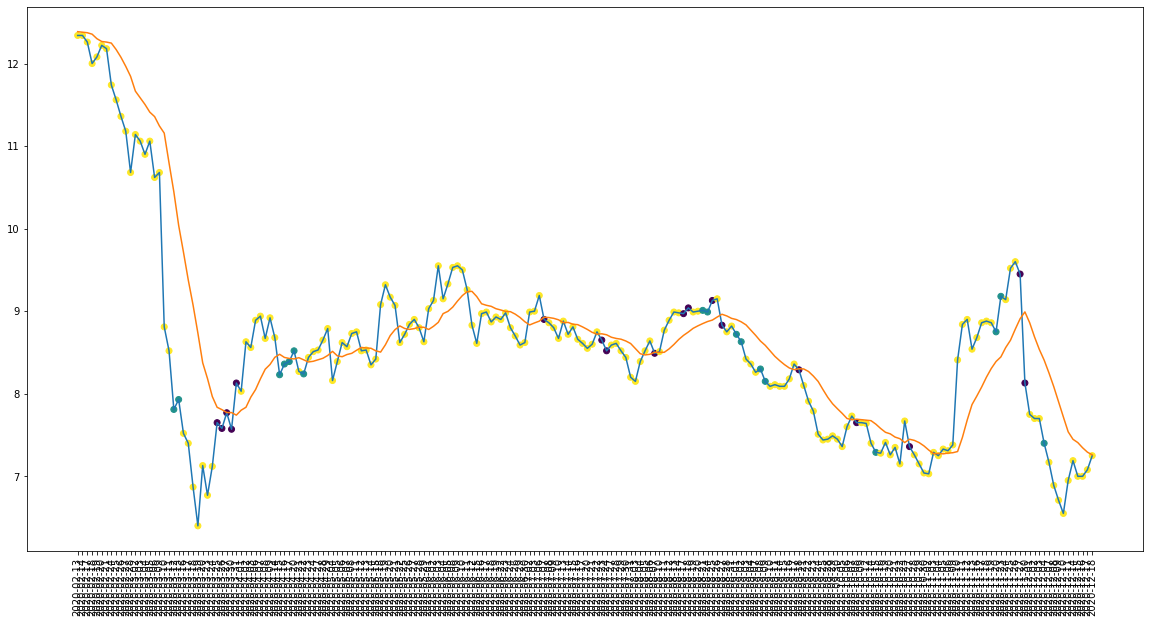

In [155]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

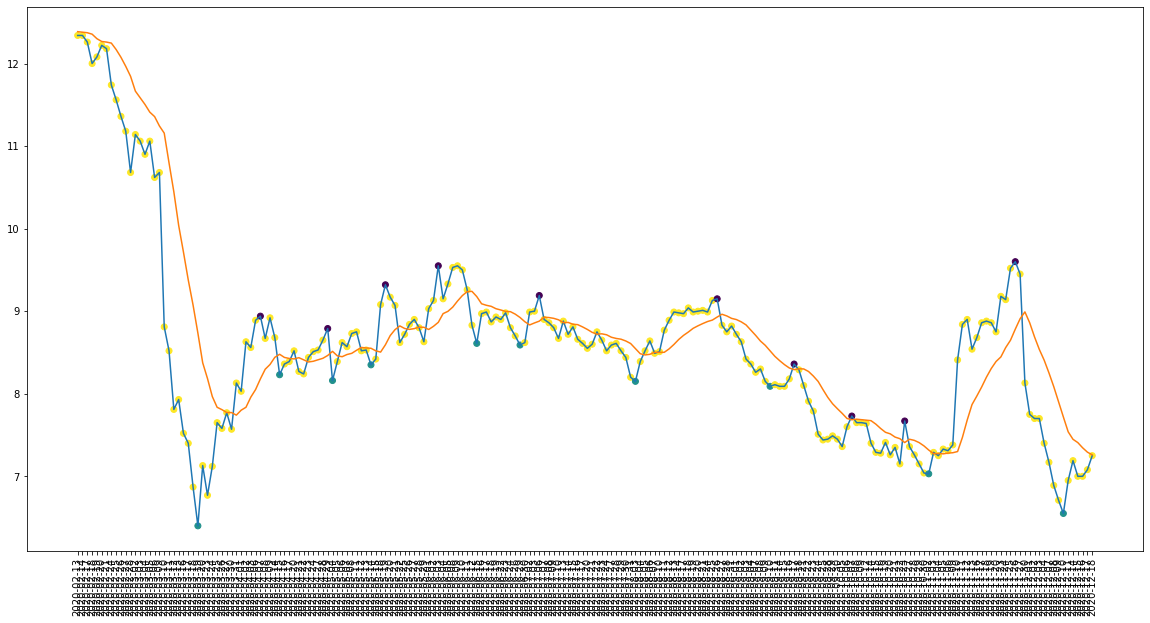

In [156]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [157]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 213
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 10
actual holds but predicted buy: 16
actual holds but predicted sell: 18
actual predicted holds: 159
Percentage buys correct: 10.0%
Percentage sells correct: 0.0%
Percentage holds correct: 82.38341968911917%
actual buys: 10
actual sells: 10
actual holds: 193


In [158]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[11.5600004196167, 11.739999771118164, 12.0, 12.079999923706055, 12.18000030517578, 12.220000267028807, 12.260000228881836, 12.34000015258789, 12.34000015258789]
[10.68000030517578, 10.899999618530273, 11.0600004196167, 11.140000343322754, 11.18000030517578, 11.359999656677244, 11.5600004196167, 11.739999771118164, 12.18000030517578]
Percentage buys correct: 41.1764705882353%
Percentage sells correct: 61.111111111111114%
Percentage holds correct: 80.7909604519774%


In [159]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $7.809999942779541
Shares owned at the moment: 1276
Cash capital at the moment: $7.034783214092386


Stop Loss Activated!

Share price: $7.519999980926514
Shares owned at the moment: 0
Cash capital at the moment: $9576.167078943252


Share price: $8.229999542236326
Shares owned at the moment: 1160
Cash capital at the moment: $3.1139114093784883


Price increase from previously bought: 7.844377094948252%
Share price: $8.899999618530273
Shares owned at the moment: 0
Cash capital at the moment: $10298.722470121384


Share price: $9.010000228881836
Shares owned at the moment: 1139
Cash capital at the moment: $8.110636208057258


Stop Loss Activated!

Share price: $8.75
Shares owned at the moment: 0
Cash capital at the moment: $9946.953448708056


Share price: $8.720000267028809
Shares owned at the moment: 1137
Cash capital at the moment: $5.047884261368381


Stop Loss Activated!

Share price: $8.420000076293945
Shares owned at the moment: 0
Cash capital at the moment: $9552.26

In [160]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5843.750896369933
profit gained: -41.56249103630067%


In [161]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.600917,33.333333333333336%,11.11111111111111%,63.5%,58.92857142857143%,57.142857142857146%,78.72340425531915%,-9.125151241259664%,-7.777238176262399%
1,0.674419,37.5%,11.11111111111111%,71.21212121212122%,54.90196078431372%,90.9090909090909%,84.9673202614379%,-27.68439793420087%,-48.34563047105195%
2,0.761468,25.0%,22.22222222222222%,80.59701492537313%,55.172413793103445%,86.66666666666667%,87.86127167630057%,3.9843991503118925%,-5.545324129943856%
3,0.800000,0.0%,30.0%,87.56476683937824%,50.0%,64.70588235294117%,86.48648648648648%,-20.71219810776589%,-7.669883276367181%
4,0.687204,12.5%,22.22222222222222%,73.19587628865979%,53.84615384615385%,58.62068965517241%,83.2258064516129%,-16.49947977055308%,-10.879329186439518%
5,0.751174,10.0%,0.0%,82.38341968911917%,41.1764705882353%,61.111111111111114%,80.7909604519774%,-10.001312134695109%,-41.56249103630067%


## JP Morgan

In [162]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14       OBV_7  labels
0  2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
1  2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2  2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
3  2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
4  2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0


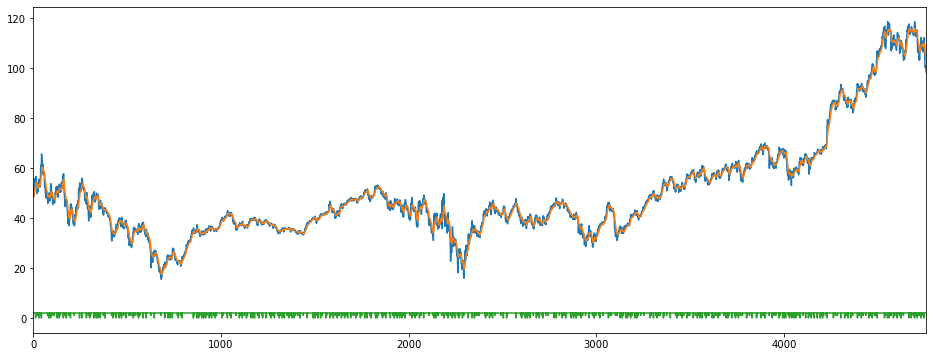

In [163]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [164]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,49.375000,48.388499,-42.592593,-2894250.0,2.0
2000-01-24,48.625000,48.424884,-39.516144,-8054850.0,2.0
2000-01-25,48.666668,48.462081,-38.709668,-1595700.0,2.0
2000-01-26,49.750000,48.660222,-17.741956,5984250.0,2.0
2000-01-27,52.291668,49.218906,-5.232557,14370900.0,2.0


In [165]:
df.drop(['OBV_7'], axis='columns', inplace=True)

In [166]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(4745, 15, 3)

In [167]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [168]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [169]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [170]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [171]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 31ms/step - loss: 0.2875 - accuracy: 0.4847 - mse: 0.4937 - weighted_accuracy: 0.3253 - weighted_mse: 0.5632 - val_loss: 0.2997 - val_accuracy: 0.0453 - val_mse: 0.3511 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3511
Epoch 2/200
30/30 [==============================] - 0s 8ms/step - loss: 0.2047 - accuracy: 0.3274 - mse: 0.8432 - weighted_accuracy: 0.4353 - weighted_mse: 0.8196 - val_loss: 0.2907 - val_accuracy: 0.0453 - val_mse: 0.3806 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3806
Epoch 3/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1863 - accuracy: 0.2885 - mse: 1.0697 - weighted_accuracy: 0.4630 - weighted_mse: 1.0362 - val_loss: 0.2806 - val_accuracy: 0.0453 - val_mse: 0.4151 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.4151
Epoch 4/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1797 - accuracy: 0.2819 - mse: 1.1928 - weighted_accuracy: 0.4926 - weighte

Epoch 30/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1408 - accuracy: 0.3525 - mse: 1.7192 - weighted_accuracy: 0.6757 - weighted_mse: 1.6285 - val_loss: 0.1830 - val_accuracy: 0.3730 - val_mse: 1.6695 - val_weighted_accuracy: 0.3730 - val_weighted_mse: 1.6695
Epoch 31/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1403 - accuracy: 0.3846 - mse: 1.7056 - weighted_accuracy: 0.6931 - weighted_mse: 1.6246 - val_loss: 0.1953 - val_accuracy: 0.3087 - val_mse: 1.7140 - val_weighted_accuracy: 0.3087 - val_weighted_mse: 1.7140
Epoch 32/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1405 - accuracy: 0.3857 - mse: 1.7200 - weighted_accuracy: 0.6899 - weighted_mse: 1.6436 - val_loss: 0.1942 - val_accuracy: 0.3098 - val_mse: 1.7072 - val_weighted_accuracy: 0.3098 - val_weighted_mse: 1.7072
Epoch 33/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1393 - accuracy: 0.3604 - mse: 1.7318 - weighted_accuracy: 0.6841 - weig

Epoch 59/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1238 - accuracy: 0.4958 - mse: 2.1027 - weighted_accuracy: 0.7549 - weighted_mse: 2.0708 - val_loss: 0.1780 - val_accuracy: 0.4742 - val_mse: 2.1635 - val_weighted_accuracy: 0.4742 - val_weighted_mse: 2.1635
Epoch 60/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1224 - accuracy: 0.5040 - mse: 2.0837 - weighted_accuracy: 0.7617 - weighted_mse: 2.0510 - val_loss: 0.1937 - val_accuracy: 0.4036 - val_mse: 2.1794 - val_weighted_accuracy: 0.4036 - val_weighted_mse: 2.1794
Epoch 61/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1227 - accuracy: 0.4984 - mse: 2.1033 - weighted_accuracy: 0.7536 - weighted_mse: 2.0670 - val_loss: 0.1791 - val_accuracy: 0.4710 - val_mse: 2.0593 - val_weighted_accuracy: 0.4710 - val_weighted_mse: 2.0593
Epoch 62/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1225 - accuracy: 0.4847 - mse: 2.1449 - weighted_accuracy: 0.7525 - weig

Epoch 88/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1079 - accuracy: 0.5927 - mse: 2.5650 - weighted_accuracy: 0.8149 - weighted_mse: 2.5876 - val_loss: 0.1838 - val_accuracy: 0.4752 - val_mse: 2.7171 - val_weighted_accuracy: 0.4752 - val_weighted_mse: 2.7171
Epoch 89/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1054 - accuracy: 0.5854 - mse: 2.6074 - weighted_accuracy: 0.8255 - weighted_mse: 2.6264 - val_loss: 0.1704 - val_accuracy: 0.5416 - val_mse: 2.7155 - val_weighted_accuracy: 0.5416 - val_weighted_mse: 2.7155
Epoch 90/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1052 - accuracy: 0.6070 - mse: 2.6853 - weighted_accuracy: 0.8258 - weighted_mse: 2.7064 - val_loss: 0.1804 - val_accuracy: 0.4763 - val_mse: 2.8467 - val_weighted_accuracy: 0.4763 - val_weighted_mse: 2.8467
Epoch 91/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1045 - accuracy: 0.5898 - mse: 2.6364 - weighted_accuracy: 0.8117 - weig

Epoch 117/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0932 - accuracy: 0.6678 - mse: 3.2469 - weighted_accuracy: 0.8501 - weighted_mse: 3.3223 - val_loss: 0.1880 - val_accuracy: 0.5248 - val_mse: 3.4800 - val_weighted_accuracy: 0.5248 - val_weighted_mse: 3.4800
Epoch 118/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0915 - accuracy: 0.6783 - mse: 3.2434 - weighted_accuracy: 0.8483 - weighted_mse: 3.2960 - val_loss: 0.1947 - val_accuracy: 0.4974 - val_mse: 3.4492 - val_weighted_accuracy: 0.4974 - val_weighted_mse: 3.4492
Epoch 119/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0896 - accuracy: 0.6834 - mse: 3.2953 - weighted_accuracy: 0.8596 - weighted_mse: 3.3756 - val_loss: 0.1876 - val_accuracy: 0.5364 - val_mse: 3.5990 - val_weighted_accuracy: 0.5364 - val_weighted_mse: 3.5990
Epoch 120/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0882 - accuracy: 0.6726 - mse: 3.2686 - weighted_accuracy: 0.8594 - 

Epoch 146/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0763 - accuracy: 0.7521 - mse: 4.0649 - weighted_accuracy: 0.8885 - weighted_mse: 4.1304 - val_loss: 0.1803 - val_accuracy: 0.5922 - val_mse: 4.0608 - val_weighted_accuracy: 0.5922 - val_weighted_mse: 4.0608
Epoch 147/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0758 - accuracy: 0.7553 - mse: 4.1444 - weighted_accuracy: 0.8951 - weighted_mse: 4.2170 - val_loss: 0.2017 - val_accuracy: 0.5669 - val_mse: 4.3804 - val_weighted_accuracy: 0.5669 - val_weighted_mse: 4.3804
Epoch 148/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0753 - accuracy: 0.7453 - mse: 4.1546 - weighted_accuracy: 0.8974 - weighted_mse: 4.2237 - val_loss: 0.1702 - val_accuracy: 0.6164 - val_mse: 4.1741 - val_weighted_accuracy: 0.6164 - val_weighted_mse: 4.1741
Epoch 149/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0780 - accuracy: 0.7534 - mse: 4.1795 - weighted_accuracy: 0.8811 - 

Epoch 175/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0617 - accuracy: 0.8135 - mse: 5.0251 - weighted_accuracy: 0.9204 - weighted_mse: 5.0582 - val_loss: 0.1669 - val_accuracy: 0.6797 - val_mse: 5.1347 - val_weighted_accuracy: 0.6797 - val_weighted_mse: 5.1347
Epoch 176/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0644 - accuracy: 0.8011 - mse: 5.1389 - weighted_accuracy: 0.9140 - weighted_mse: 5.1744 - val_loss: 0.1697 - val_accuracy: 0.6607 - val_mse: 5.3597 - val_weighted_accuracy: 0.6607 - val_weighted_mse: 5.3597
Epoch 177/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0635 - accuracy: 0.8045 - mse: 5.1738 - weighted_accuracy: 0.9192 - weighted_mse: 5.2070 - val_loss: 0.1645 - val_accuracy: 0.6691 - val_mse: 5.3344 - val_weighted_accuracy: 0.6691 - val_weighted_mse: 5.3344
Epoch 178/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0641 - accuracy: 0.8090 - mse: 5.2011 - weighted_accuracy: 0.9170 - 

In [172]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

Test loss: 0.15947556495666504
Test accuracy: 0.7376185655593872


In [173]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.7783182  -3.916218    0.68099195]
 [-0.89351684 -3.3900983   0.47173166]
 [-1.8311921  -4.223629    1.2597075 ]
 ...
 [-1.9137393  -3.6034677   0.889022  ]
 [-0.20591831 -3.9826338  -0.19011259]
 [-0.1978235  -2.7254732  -0.09236886]]


Counter({2: 747, 0: 115, 1: 87})

In [174]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 865, 0: 41, 1: 43})

In [175]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 949
actual predicted buys: 9
actual buys but predicted sell: 2
actual buys but predicted hold: 32
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 32
actual holds but predicted buy: 77
actual holds but predicted sell: 105
actual predicted holds: 683
Percentage buys correct: 20.930232558139537%
Percentage sells correct: 19.51219512195122%
Percentage holds correct: 78.95953757225433%
actual buys: 43
actual sells: 41
actual holds: 865


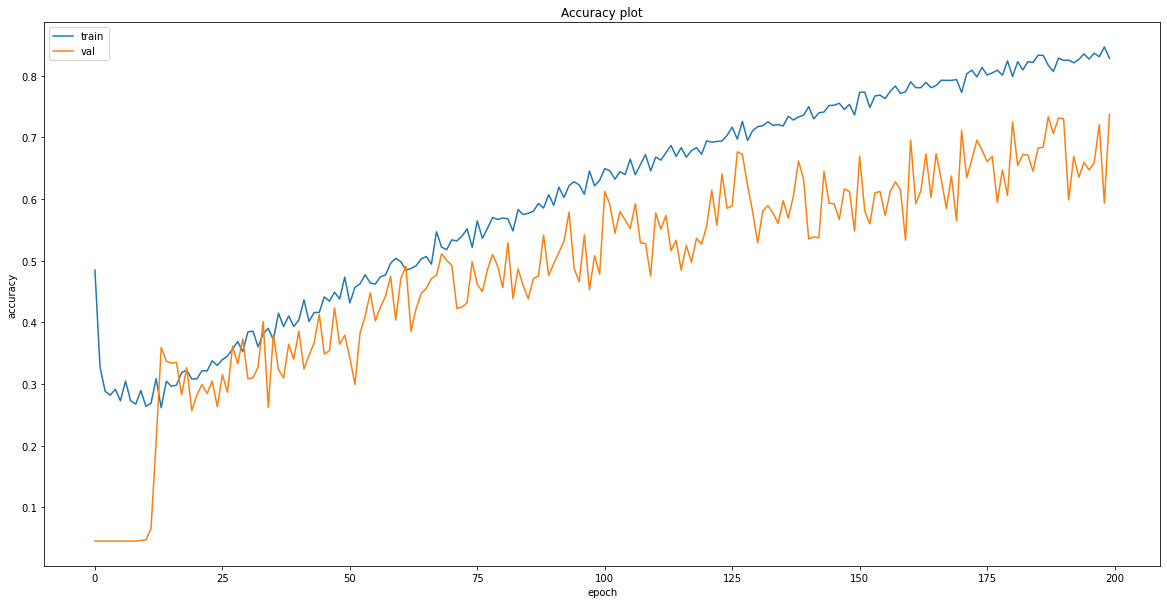

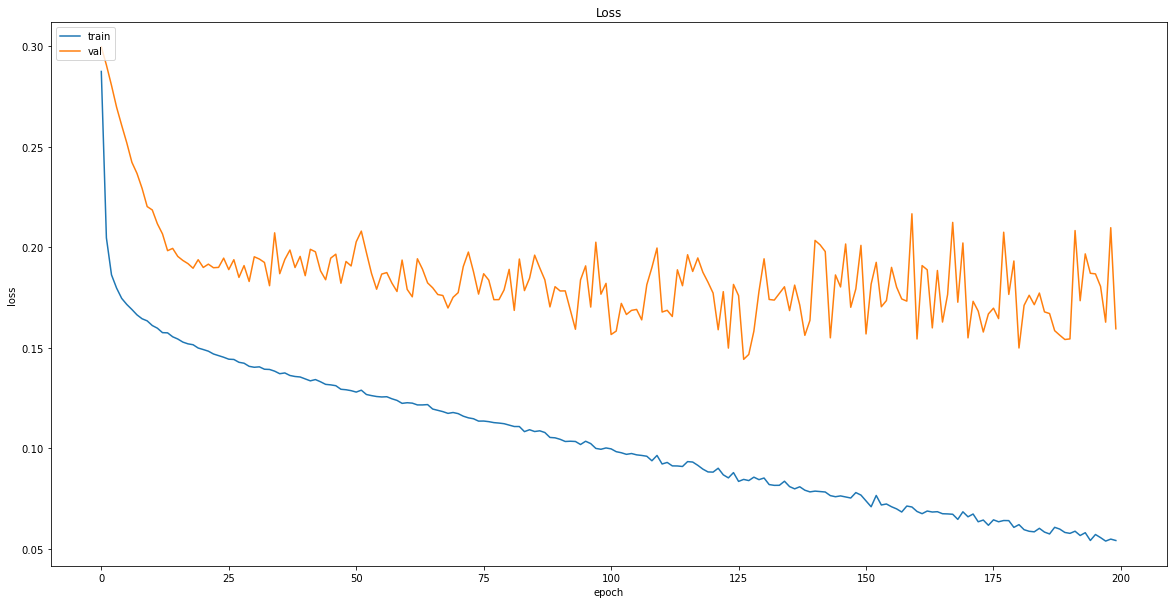

In [176]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [177]:
# Save model
model.save("models/{}".format('jpm_time_series_lstm_buy_hold_sell_no_obv.model'))

INFO:tensorflow:Assets written to: models/jpm_time_series_lstm_buy_hold_sell_no_obv.model\assets


### Test Performance

### non-recession

In [178]:
logger = []

In [179]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2019-01-22   104.589996  101.198442  -3.459880  84335200.0     2.0
2019-01-23   102.940002  101.466374 -21.874992  67251500.0     2.0
2019-01-24   102.680000  101.653086 -27.040213  55104800.0     2.0
2019-01-25   102.739998  101.820303 -32.628441  66401600.0     2.0
2019-01-28   103.389999  102.061795 -23.968276  80771000.0     2.0


In [180]:
df.drop(['OBV_7'], axis='columns', inplace=True)

In [181]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(218, 15, 3)

In [182]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [183]:
model = tf.keras.models.load_model("models/jpm_time_series_lstm_buy_hold_sell_no_obv.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 4ms/step - loss: 0.1425 - accuracy: 0.7431 - mean_squared_error: 5.7654 - weighted_accuracy: 0.7431 - weighted_mean_squared_error: 5.7654
Test loss: 0.14253903925418854
Test accuracy: 0.7431192398071289


In [184]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 169, 0: 31, 1: 18})

In [185]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [186]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test.csv")
df.set_index('Date', inplace=True)

In [187]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,100.879997,102.975915,-74.903417,73097300.0,1.0,2,1
2019-02-12,102.599998,102.653466,-84.169891,62118800.0,2.0,2,2
2019-02-13,103.089996,102.645240,-50.965236,74971100.0,2.0,2,2
2019-02-14,102.419998,102.713664,-41.505819,85725200.0,2.0,2,2
2019-02-15,105.550003,102.668485,-54.440145,74206700.0,2.0,2,2


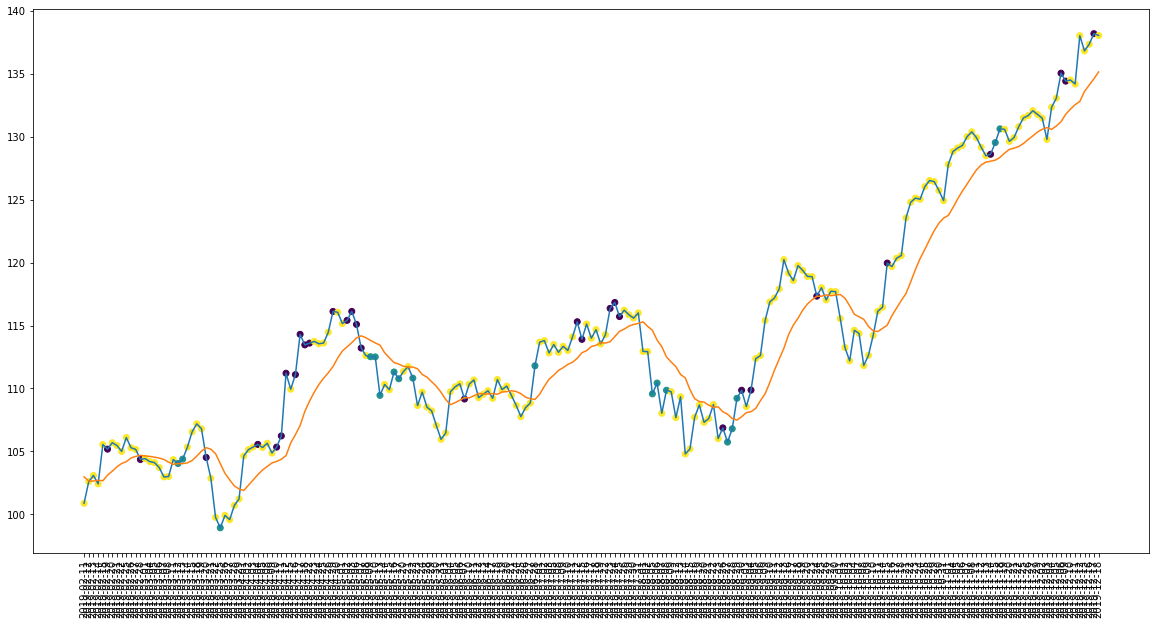

In [188]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

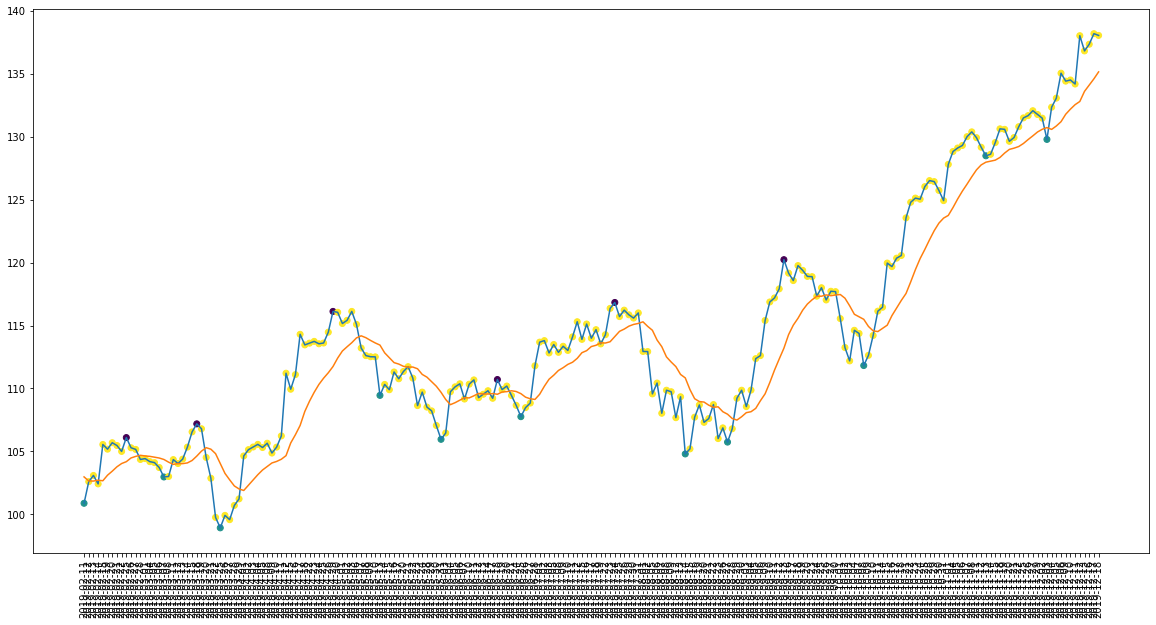

In [189]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [190]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 4
actual holds but predicted buy: 15
actual holds but predicted sell: 29
actual predicted holds: 157
Percentage buys correct: 27.272727272727273%
Percentage sells correct: 33.333333333333336%
Percentage holds correct: 78.1094527363184%
actual buys: 11
actual sells: 6
actual holds: 201


In [191]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[100.87999725341795, 102.41999816894531, 102.5999984741211, 103.08999633789062, 105.0, 105.18000030517578, 105.47000122070312, 105.5500030517578, 105.69000244140624]
[104.19000244140624, 104.36000061035156, 104.43000030517578, 105.0, 105.16000366210938, 105.29000091552734, 105.47000122070312, 105.69000244140624, 106.0999984741211]
Percentage buys correct: 38.888888888888886%
Percentage sells correct: 41.935483870967744%
Percentage holds correct: 86.9047619047619%


In [192]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $104.04000091552734
Shares owned at the moment: 95
Cash capital at the moment: $89.01946278571995


Stop Loss Activated!

Share price: $99.76000213623048
Shares owned at the moment: 0
Cash capital at the moment: $9540.157365169525


Share price: $98.93000030517578
Shares owned at the moment: 96
Cash capital at the moment: $16.759815792083828


Price increase from previously bought: 6.409080510216225%
Share price: $105.55999755859376
Shares owned at the moment: 0
Cash capital at the moment: $10122.651742061616


Share price: $112.5199966430664
Shares owned at the moment: 89
Cash capital at the moment: $80.83277165031541


Stop Loss Activated!

Share price: $108.63999938964844
Shares owned at the moment: 0
Cash capital at the moment: $9723.203077478409


Share price: $111.8000030517578
Shares owned at the moment: 86
Cash capital at the moment: $81.96211430549738


Stop Loss Activated!

Share price: $108.02999877929688
Shares owned at the moment: 0
Cash capital at the moment:

In [193]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $13577.290673755644
profit gained: 35.77290673755644%


In [194]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.600917,33.333333333333336%,11.11111111111111%,63.5%,58.92857142857143%,57.142857142857146%,78.72340425531915%,-9.125151241259664%,-7.777238176262399%
1,0.674419,37.5%,11.11111111111111%,71.21212121212122%,54.90196078431372%,90.9090909090909%,84.9673202614379%,-27.68439793420087%,-48.34563047105195%
2,0.761468,25.0%,22.22222222222222%,80.59701492537313%,55.172413793103445%,86.66666666666667%,87.86127167630057%,3.9843991503118925%,-5.545324129943856%
3,0.800000,0.0%,30.0%,87.56476683937824%,50.0%,64.70588235294117%,86.48648648648648%,-20.71219810776589%,-7.669883276367181%
4,0.687204,12.5%,22.22222222222222%,73.19587628865979%,53.84615384615385%,58.62068965517241%,83.2258064516129%,-16.49947977055308%,-10.879329186439518%
5,0.751174,10.0%,0.0%,82.38341968911917%,41.1764705882353%,61.111111111111114%,80.7909604519774%,-10.001312134695109%,-41.56249103630067%
6,0.743119,27.272727272727273%,33.333333333333336%,78.1094527363184%,38.888888888888886%,41.935483870967744%,86.9047619047619%,3.769556171989407%,35.77290673755644%


### recession

In [195]:
logger = []

In [196]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-01-22   136.839996  137.690058 -77.454723  33776700.0     2.0
2020-01-23   136.679993  137.534664 -80.363881  26227600.0     2.0
2020-01-24   136.539993  137.381637 -69.867648  16881900.0     2.0
2020-01-27   133.149994  136.730615 -90.166021   1715500.0     1.0
2020-01-28   132.029999  136.007444 -79.004573 -11145000.0     2.0


In [197]:
df.drop(['OBV_7'], axis='columns', inplace=True)

In [198]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(219, 15, 3)

In [199]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [200]:
model = tf.keras.models.load_model("models/jpm_time_series_lstm_buy_hold_sell_no_obv.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1649 - accuracy: 0.7169 - mean_squared_error: 5.2367 - weighted_accuracy: 0.7169 - weighted_mean_squared_error: 5.2367
Test loss: 0.16494491696357727
Test accuracy: 0.7168949842453003


In [201]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 171, 0: 26, 1: 22})

In [202]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [203]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test2.csv")
df.set_index('Date', inplace=True)

In [204]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,138.000000,136.179383,-6.410124,26757600.0,0.0,2,0
2020-02-12,138.000000,136.459478,-9.001177,33336200.0,2.0,2,2
2020-02-13,137.880005,136.696481,-13.465502,33336200.0,2.0,2,2
2020-02-14,137.460007,136.878562,-14.718062,25888700.0,2.0,0,2
2020-02-18,135.639999,136.968015,-23.401387,19261100.0,2.0,1,2


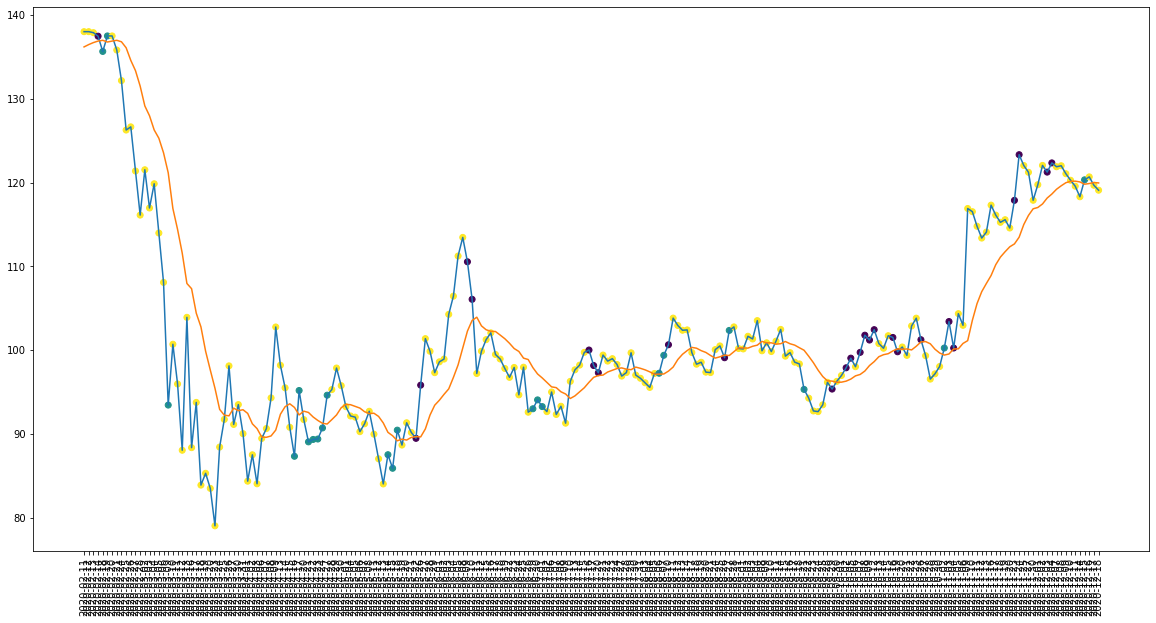

In [205]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

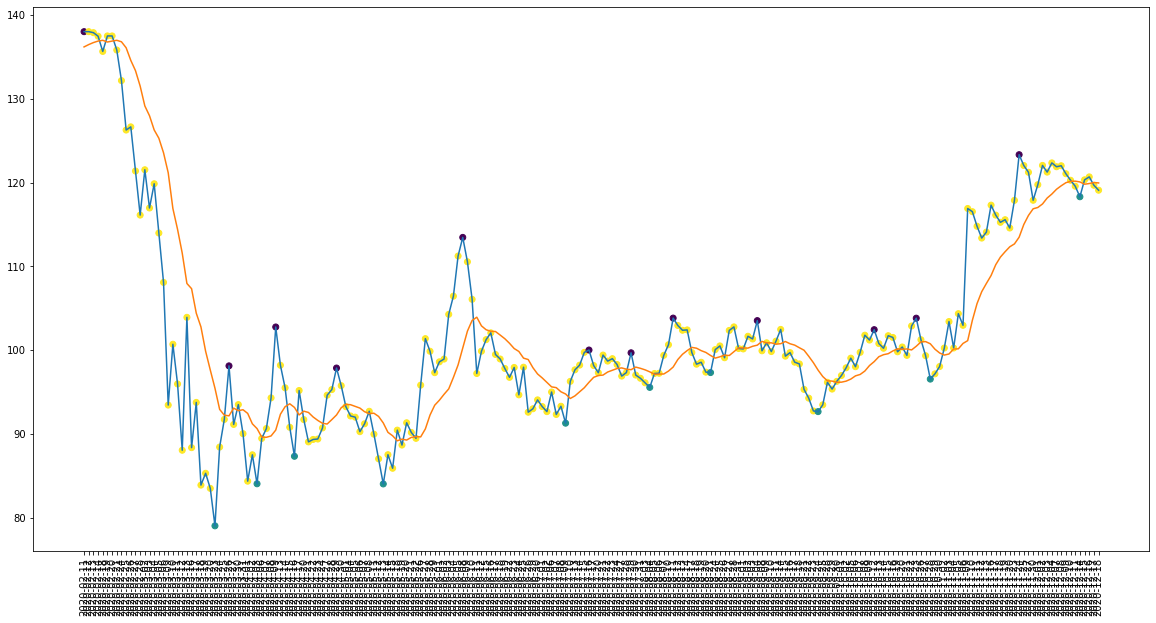

In [206]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [207]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 9
actual holds but predicted buy: 21
actual holds but predicted sell: 23
actual predicted holds: 153
Percentage buys correct: 10.0%
Percentage sells correct: 25.0%
Percentage holds correct: 77.66497461928934%
actual buys: 10
actual sells: 12
actual holds: 197


In [208]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[132.16000366210938, 135.63999938964844, 135.80999755859378, 137.46000671386722, 137.49000549316406, 137.49000549316406, 137.8800048828125, 138.0, 138.0]
[116.11000061035156, 116.95999908447266, 121.37000274658205, 121.5199966430664, 126.26000213623048, 126.63999938964844, 132.16000366210938, 135.80999755859378, 137.49000549316406]
Percentage buys correct: 45.45454545454545%
Percentage sells correct: 46.15384615384615%
Percentage holds correct: 81.17647058823529%


In [209]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $135.63999938964844
Shares owned at the moment: 73
Cash capital at the moment: $71.05031467819208


Stop Loss Activated!

Share price: $126.26000213623048
Shares owned at the moment: 0
Cash capital at the moment: $9262.68377519417


Share price: $93.44000244140624
Shares owned at the moment: 98
Cash capital at the moment: $80.38145527839879


Stop Loss Activated!

Share price: $88.05000305175781
Shares owned at the moment: 0
Cash capital at the moment: $8685.552278528216


Share price: $87.33000183105469
Shares owned at the moment: 99
Cash capital at the moment: $16.106504255296386


Stop Loss Activated!

Share price: $84.02999877929688
Shares owned at the moment: 0
Cash capital at the moment: $8312.199216238023


Share price: $87.5199966430664
Shares owned at the moment: 94
Cash capital at the moment: $62.69561265754783


Price increase from previously bought: 9.183296403485365%
Share price: $95.81999969482422
Shares owned at the moment: 0
Cash capital at the moment: $904

In [210]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $8586.858291473387
profit gained: -14.13141708526613%


In [211]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.600917,33.333333333333336%,11.11111111111111%,63.5%,58.92857142857143%,57.142857142857146%,78.72340425531915%,-9.125151241259664%,-7.777238176262399%
1,0.674419,37.5%,11.11111111111111%,71.21212121212122%,54.90196078431372%,90.9090909090909%,84.9673202614379%,-27.68439793420087%,-48.34563047105195%
2,0.761468,25.0%,22.22222222222222%,80.59701492537313%,55.172413793103445%,86.66666666666667%,87.86127167630057%,3.9843991503118925%,-5.545324129943856%
3,0.800000,0.0%,30.0%,87.56476683937824%,50.0%,64.70588235294117%,86.48648648648648%,-20.71219810776589%,-7.669883276367181%
4,0.687204,12.5%,22.22222222222222%,73.19587628865979%,53.84615384615385%,58.62068965517241%,83.2258064516129%,-16.49947977055308%,-10.879329186439518%
5,0.751174,10.0%,0.0%,82.38341968911917%,41.1764705882353%,61.111111111111114%,80.7909604519774%,-10.001312134695109%,-41.56249103630067%
6,0.743119,27.272727272727273%,33.333333333333336%,78.1094527363184%,38.888888888888886%,41.935483870967744%,86.9047619047619%,3.769556171989407%,35.77290673755644%
7,0.716895,10.0%,25.0%,77.66497461928934%,45.45454545454545%,46.15384615384615%,81.17647058823529%,7.158475455837287%,-14.13141708526613%


## American Axle & Manufacturing Holdings, Inc

In [212]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14     OBV_7  labels
0  2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
1  2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2  2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
3  2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
4  2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0


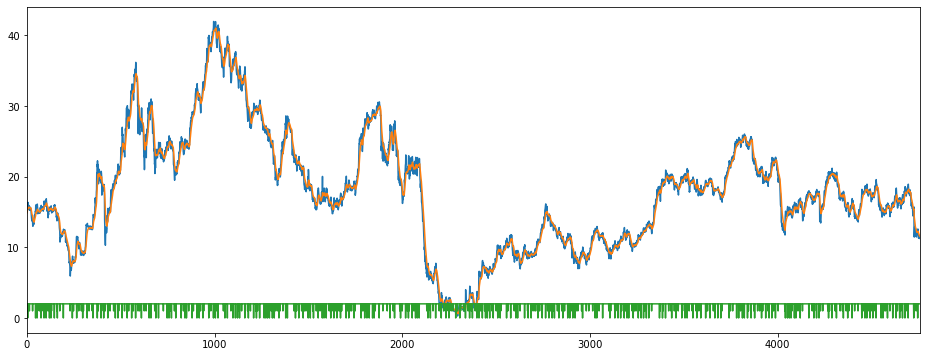

In [213]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [214]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,16.0625,14.895987,-18.478261,298700.0,2.0
2000-01-24,15.8750,15.046605,-22.222222,293100.0,2.0
2000-01-25,15.7500,15.154819,-26.190476,286300.0,2.0
2000-01-26,15.7500,15.246386,-29.729730,286300.0,2.0
2000-01-27,16.0000,15.362326,-25.000000,311700.0,0.0


In [215]:
df.drop(['OBV_7'], axis='columns', inplace=True)

In [216]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(4745, 15, 3)

In [217]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [218]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [219]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [220]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [221]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 31ms/step - loss: 0.2860 - accuracy: 0.4995 - mse: 0.4788 - weighted_accuracy: 0.3348 - weighted_mse: 0.5575 - val_loss: 0.3001 - val_accuracy: 0.0464 - val_mse: 0.3523 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.3523
Epoch 2/200
30/30 [==============================] - 0s 8ms/step - loss: 0.2049 - accuracy: 0.2845 - mse: 0.8589 - weighted_accuracy: 0.4219 - weighted_mse: 0.8410 - val_loss: 0.2900 - val_accuracy: 0.0464 - val_mse: 0.3819 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.3819
Epoch 3/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1886 - accuracy: 0.2432 - mse: 1.0770 - weighted_accuracy: 0.4851 - weighted_mse: 1.0480 - val_loss: 0.2778 - val_accuracy: 0.0464 - val_mse: 0.4162 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.4162
Epoch 4/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1824 - accuracy: 0.2453 - mse: 1.1847 - weighted_accuracy: 0.4932 - weighte

Epoch 30/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1435 - accuracy: 0.3398 - mse: 1.6377 - weighted_accuracy: 0.6666 - weighted_mse: 1.5349 - val_loss: 0.1980 - val_accuracy: 0.3087 - val_mse: 1.6005 - val_weighted_accuracy: 0.3087 - val_weighted_mse: 1.6005
Epoch 31/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1436 - accuracy: 0.3854 - mse: 1.6061 - weighted_accuracy: 0.6724 - weighted_mse: 1.5209 - val_loss: 0.2006 - val_accuracy: 0.3109 - val_mse: 1.6292 - val_weighted_accuracy: 0.3109 - val_weighted_mse: 1.6292
Epoch 32/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1422 - accuracy: 0.3401 - mse: 1.6617 - weighted_accuracy: 0.6777 - weighted_mse: 1.5554 - val_loss: 0.1957 - val_accuracy: 0.3256 - val_mse: 1.6061 - val_weighted_accuracy: 0.3256 - val_weighted_mse: 1.6061
Epoch 33/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1415 - accuracy: 0.3599 - mse: 1.6586 - weighted_accuracy: 0.6721 - weig

30/30 [==============================] - 0s 7ms/step - loss: 0.1271 - accuracy: 0.4563 - mse: 2.0101 - weighted_accuracy: 0.7385 - weighted_mse: 1.9487 - val_loss: 0.1959 - val_accuracy: 0.3836 - val_mse: 1.9597 - val_weighted_accuracy: 0.3836 - val_weighted_mse: 1.9597
Epoch 59/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1269 - accuracy: 0.4905 - mse: 1.9647 - weighted_accuracy: 0.7419 - weighted_mse: 1.9123 - val_loss: 0.1787 - val_accuracy: 0.4679 - val_mse: 2.1172 - val_weighted_accuracy: 0.4679 - val_weighted_mse: 2.1172
Epoch 60/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1252 - accuracy: 0.4636 - mse: 2.0081 - weighted_accuracy: 0.7394 - weighted_mse: 1.9551 - val_loss: 0.1893 - val_accuracy: 0.4141 - val_mse: 2.1036 - val_weighted_accuracy: 0.4141 - val_weighted_mse: 2.1036
Epoch 61/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1241 - accuracy: 0.5205 - mse: 2.0117 - weighted_accuracy: 0.7603 - weighted_mse: 1.9

Epoch 87/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1113 - accuracy: 0.5906 - mse: 2.3955 - weighted_accuracy: 0.8115 - weighted_mse: 2.3881 - val_loss: 0.1817 - val_accuracy: 0.4858 - val_mse: 2.5803 - val_weighted_accuracy: 0.4858 - val_weighted_mse: 2.5803
Epoch 88/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1111 - accuracy: 0.5893 - mse: 2.4054 - weighted_accuracy: 0.7928 - weighted_mse: 2.3931 - val_loss: 0.1768 - val_accuracy: 0.5364 - val_mse: 2.5009 - val_weighted_accuracy: 0.5364 - val_weighted_mse: 2.5009
Epoch 89/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1098 - accuracy: 0.5922 - mse: 2.4327 - weighted_accuracy: 0.8048 - weighted_mse: 2.4213 - val_loss: 0.2066 - val_accuracy: 0.4289 - val_mse: 2.5438 - val_weighted_accuracy: 0.4289 - val_weighted_mse: 2.5438
Epoch 90/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1083 - accuracy: 0.5796 - mse: 2.4724 - weighted_accuracy: 0.8129 - weig

Epoch 116/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0960 - accuracy: 0.6586 - mse: 2.9300 - weighted_accuracy: 0.8492 - weighted_mse: 2.9836 - val_loss: 0.1700 - val_accuracy: 0.5933 - val_mse: 3.1065 - val_weighted_accuracy: 0.5933 - val_weighted_mse: 3.1065
Epoch 117/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0946 - accuracy: 0.6610 - mse: 2.9373 - weighted_accuracy: 0.8464 - weighted_mse: 2.9632 - val_loss: 0.1901 - val_accuracy: 0.5627 - val_mse: 2.8913 - val_weighted_accuracy: 0.5627 - val_weighted_mse: 2.8913
Epoch 118/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0968 - accuracy: 0.6744 - mse: 3.0085 - weighted_accuracy: 0.8386 - weighted_mse: 3.0611 - val_loss: 0.1860 - val_accuracy: 0.5574 - val_mse: 3.1981 - val_weighted_accuracy: 0.5574 - val_weighted_mse: 3.1981
Epoch 119/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0947 - accuracy: 0.6649 - mse: 3.0073 - weighted_accuracy: 0.8515 - 

Epoch 145/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0826 - accuracy: 0.7347 - mse: 3.6349 - weighted_accuracy: 0.8863 - weighted_mse: 3.7164 - val_loss: 0.1772 - val_accuracy: 0.6280 - val_mse: 3.7640 - val_weighted_accuracy: 0.6280 - val_weighted_mse: 3.7640
Epoch 146/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0826 - accuracy: 0.7302 - mse: 3.6889 - weighted_accuracy: 0.8737 - weighted_mse: 3.7451 - val_loss: 0.1819 - val_accuracy: 0.5869 - val_mse: 3.6980 - val_weighted_accuracy: 0.5869 - val_weighted_mse: 3.6980
Epoch 147/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0812 - accuracy: 0.7242 - mse: 3.6700 - weighted_accuracy: 0.8842 - weighted_mse: 3.7262 - val_loss: 0.1760 - val_accuracy: 0.5933 - val_mse: 3.7265 - val_weighted_accuracy: 0.5933 - val_weighted_mse: 3.7265
Epoch 148/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0796 - accuracy: 0.7537 - mse: 3.7182 - weighted_accuracy: 0.8969 - 

Epoch 174/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0706 - accuracy: 0.7763 - mse: 4.5637 - weighted_accuracy: 0.8997 - weighted_mse: 4.5837 - val_loss: 0.1845 - val_accuracy: 0.6596 - val_mse: 5.0392 - val_weighted_accuracy: 0.6596 - val_weighted_mse: 5.0392
Epoch 175/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0687 - accuracy: 0.7877 - mse: 4.6423 - weighted_accuracy: 0.9038 - weighted_mse: 4.6617 - val_loss: 0.1805 - val_accuracy: 0.6502 - val_mse: 4.5786 - val_weighted_accuracy: 0.6502 - val_weighted_mse: 4.5786
Epoch 176/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0702 - accuracy: 0.7745 - mse: 4.7210 - weighted_accuracy: 0.9008 - weighted_mse: 4.7582 - val_loss: 0.1882 - val_accuracy: 0.6365 - val_mse: 5.0556 - val_weighted_accuracy: 0.6365 - val_weighted_mse: 5.0556
Epoch 177/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0673 - accuracy: 0.7806 - mse: 4.7438 - weighted_accuracy: 0.9085 - 

In [222]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

Test loss: 0.18190063536167145
Test accuracy: 0.6754478216171265


In [223]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.276739   -4.477184    1.7153605 ]
 [-1.1455083  -3.9545767  -0.04733065]
 [-4.5767517  -1.2044921   0.60144883]
 ...
 [-1.1254245  -1.121284   -0.5386804 ]
 [-1.0106163  -2.1409397   0.14152257]
 [-1.3115029  -5.303865    0.94958234]]


Counter({2: 697, 1: 136, 0: 116})

In [224]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 862, 0: 43, 1: 44})

In [225]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 949
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 36
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 34
actual holds but predicted buy: 127
actual holds but predicted sell: 108
actual predicted holds: 627
Percentage buys correct: 15.909090909090908%
Percentage sells correct: 16.27906976744186%
Percentage holds correct: 72.73781902552204%
actual buys: 44
actual sells: 43
actual holds: 862


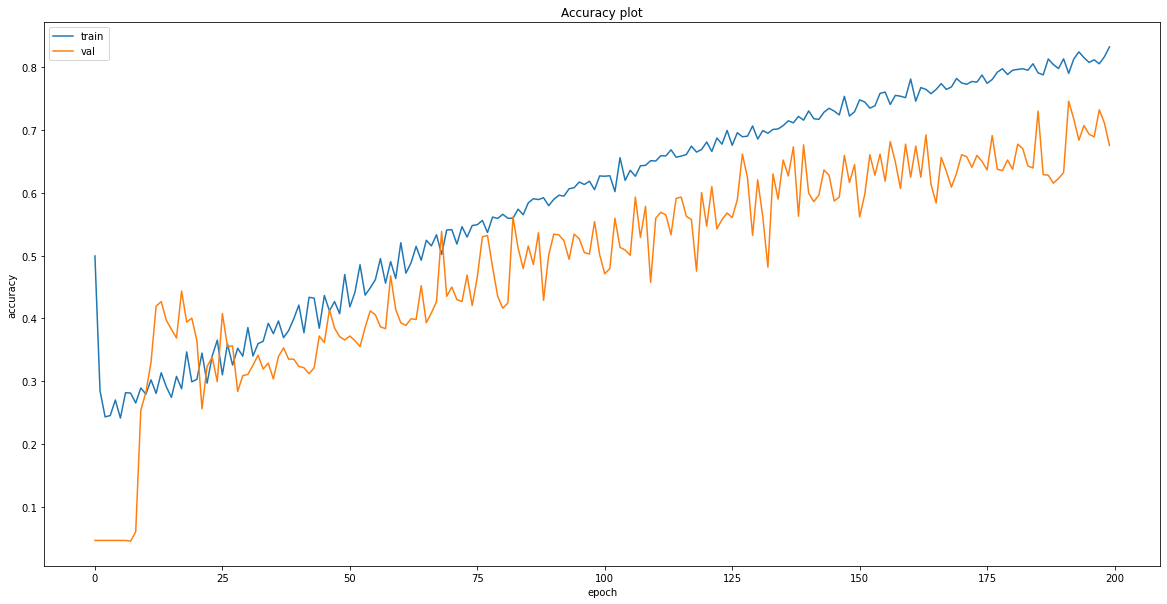

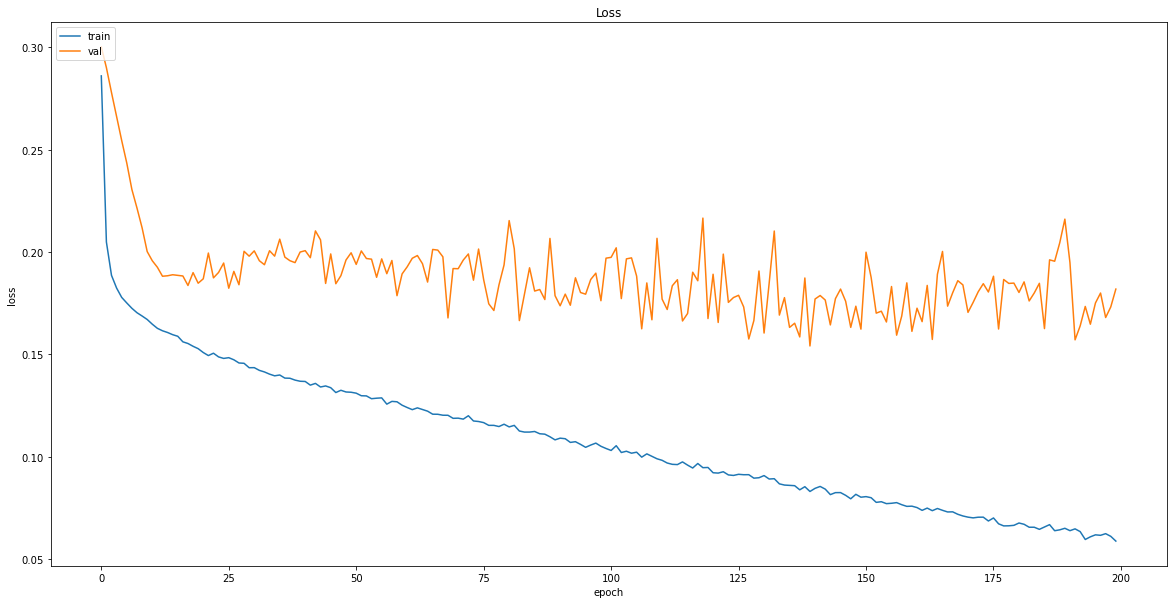

In [226]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [227]:
# Save model
model.save("models/{}".format('axl_time_series_lstm_buy_hold_sell_no_obv.model'))

INFO:tensorflow:Assets written to: models/axl_time_series_lstm_buy_hold_sell_no_obv.model\assets


### Test Performance

### non-recession

In [228]:
logger = []

In [229]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22        14.61  13.028180  -0.258404  23356600.0     2.0
2019-01-23        14.52  13.257691  -3.886001  21174700.0     2.0
2019-01-24        14.18  13.399585 -13.535906  19629300.0     2.0
2019-01-25        14.38  13.550418  -8.579880  20903300.0     2.0
2019-01-28        14.71  13.728815  -4.790414  22287500.0     2.0


In [230]:
df.drop(['OBV_7'], axis='columns', inplace=True)

In [231]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(218, 15, 3)

In [232]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [233]:
model = tf.keras.models.load_model("models/axl_time_series_lstm_buy_hold_sell_no_obv.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1931 - accuracy: 0.5826 - mean_squared_error: 5.4618 - weighted_accuracy: 0.5826 - weighted_mean_squared_error: 5.4618
Test loss: 0.19310931861400604
Test accuracy: 0.5825688242912292


In [234]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({1: 48, 2: 134, 0: 36})

In [235]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [236]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test.csv")
df.set_index('Date', inplace=True)

In [237]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,14.01,14.312907,-83.060094,17347800.0,2.0,1,2
2019-02-12,14.34,14.266306,-68.852439,19189100.0,2.0,1,2
2019-02-13,14.45,14.277643,-50.819664,21493700.0,2.0,2,2
2019-02-14,14.70,14.304160,-44.808757,23008200.0,2.0,2,2
2019-02-15,16.83,14.365058,-31.147561,25735200.0,2.0,2,2


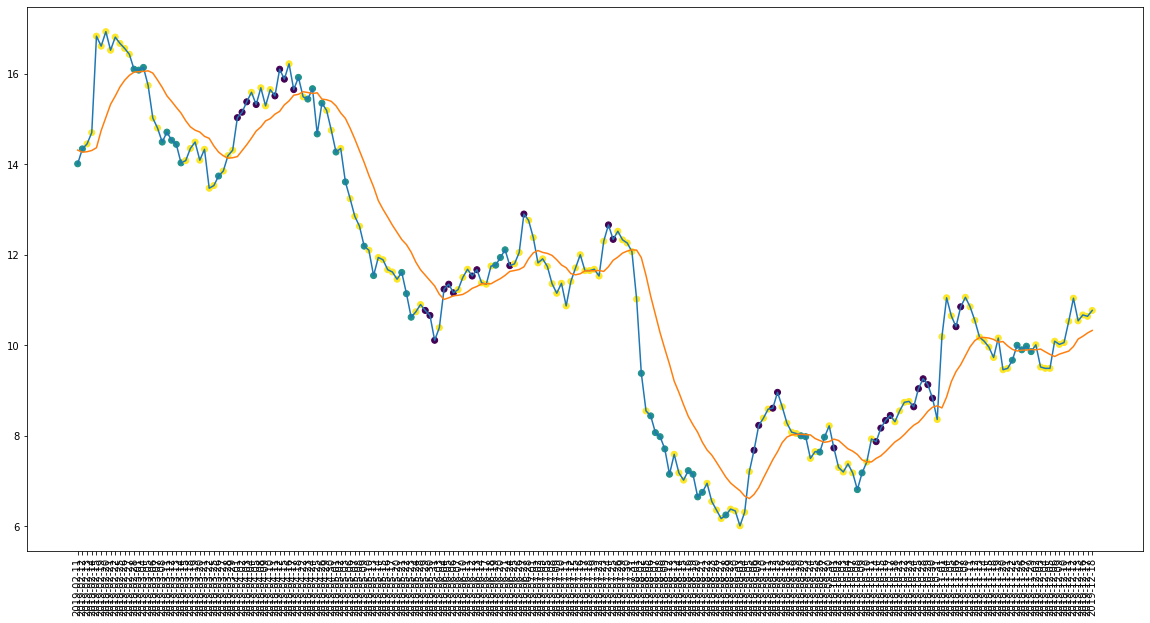

In [238]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

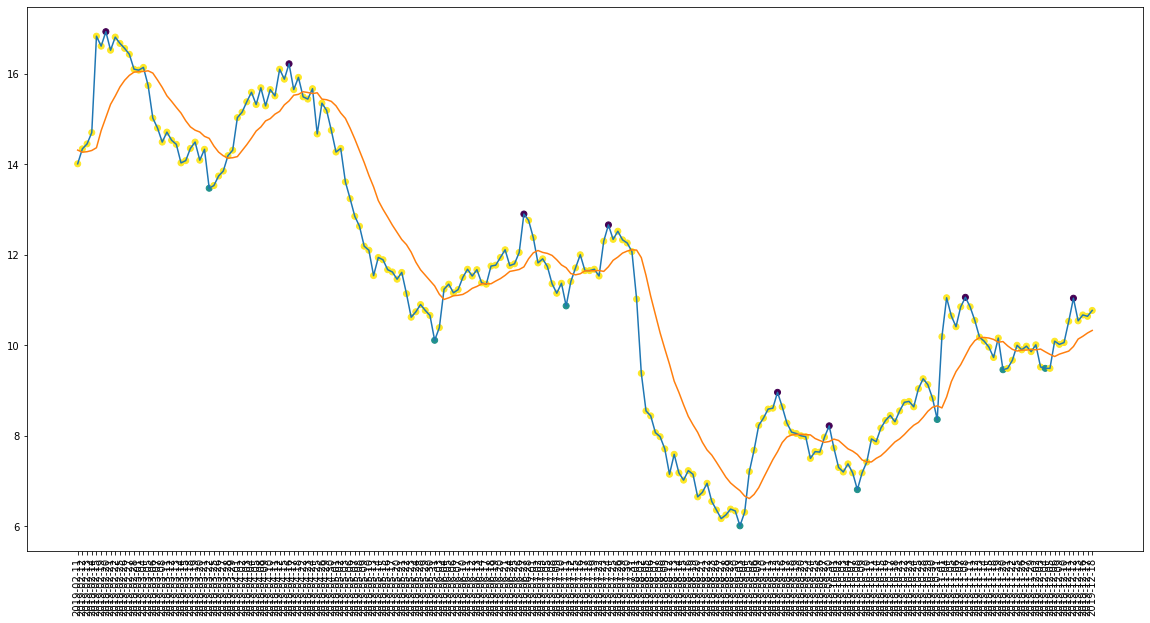

In [239]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [240]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 1
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 5
actual holds but predicted buy: 47
actual holds but predicted sell: 32
actual predicted holds: 123
Percentage buys correct: 12.5%
Percentage sells correct: 37.5%
Percentage holds correct: 60.89108910891089%
actual buys: 8
actual sells: 8
actual holds: 202


In [241]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[14.010000228881836, 14.34000015258789, 14.449999809265135, 14.699999809265135, 16.520000457763672, 16.610000610351562, 16.809999465942386, 16.829999923706055, 16.930000305175778]
[16.079999923706055, 16.100000381469727, 16.139999389648438, 16.430000305175778, 16.520000457763672, 16.559999465942386, 16.670000076293945, 16.809999465942386, 16.930000305175778]
Percentage buys correct: 41.666666666666664%
Percentage sells correct: 55.55555555555556%
Percentage holds correct: 84.21052631578948%


In [242]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $14.010000228881836
Shares owned at the moment: 711
Cash capital at the moment: $11.496784317492711


Stop Loss Activated!

Share price: $13.470000267028807
Shares owned at the moment: 0
Cash capital at the moment: $9562.329756152865


Share price: $13.739999771118164
Shares owned at the moment: 694
Cash capital at the moment: $0.547125433680776


Price increase from previously bought: 9.08865237294625%
Share price: $15.029999732971193
Shares owned at the moment: 0
Cash capital at the moment: $10402.682185625314


Share price: $15.920000076293945
Shares owned at the moment: 651
Cash capital at the moment: $10.261355821368852


Stop Loss Activated!

Share price: $15.4399995803833
Shares owned at the moment: 0
Cash capital at the moment: $10034.059623402116


Share price: $15.4399995803833
Shares owned at the moment: 648
Cash capital at the moment: $1.425816061493606


Stop Loss Activated!

Share price: $14.670000076293945
Shares owned at the moment: 0
Cash capital at the mo

In [243]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7647.909066392421
profit gained: -23.520909336075793%


In [244]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.600917,33.333333333333336%,11.11111111111111%,63.5%,58.92857142857143%,57.142857142857146%,78.72340425531915%,-9.125151241259664%,-7.777238176262399%
1,0.674419,37.5%,11.11111111111111%,71.21212121212122%,54.90196078431372%,90.9090909090909%,84.9673202614379%,-27.68439793420087%,-48.34563047105195%
2,0.761468,25.0%,22.22222222222222%,80.59701492537313%,55.172413793103445%,86.66666666666667%,87.86127167630057%,3.9843991503118925%,-5.545324129943856%
3,0.800000,0.0%,30.0%,87.56476683937824%,50.0%,64.70588235294117%,86.48648648648648%,-20.71219810776589%,-7.669883276367181%
4,0.687204,12.5%,22.22222222222222%,73.19587628865979%,53.84615384615385%,58.62068965517241%,83.2258064516129%,-16.49947977055308%,-10.879329186439518%
5,0.751174,10.0%,0.0%,82.38341968911917%,41.1764705882353%,61.111111111111114%,80.7909604519774%,-10.001312134695109%,-41.56249103630067%
6,0.743119,27.272727272727273%,33.333333333333336%,78.1094527363184%,38.888888888888886%,41.935483870967744%,86.9047619047619%,3.769556171989407%,35.77290673755644%
7,0.716895,10.0%,25.0%,77.66497461928934%,45.45454545454545%,46.15384615384615%,81.17647058823529%,7.158475455837287%,-14.13141708526613%
8,0.582569,12.5%,37.5%,60.89108910891089%,41.666666666666664%,55.55555555555556%,84.21052631578948%,-47.906362918296026%,-23.520909336075793%


### recession

In [245]:
logger = []

In [246]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-01-22         9.39  9.715390 -73.059349 -3592400.0     2.0
2020-01-23         9.34  9.657637 -75.342463 -4550300.0     2.0
2020-01-24         9.50  9.633386 -65.000010 -3092000.0     2.0
2020-01-27         9.31  9.583634 -66.883101 -4332600.0     2.0
2020-01-28         9.39  9.553844 -61.688301 -2300800.0     2.0


In [247]:
df.drop(['OBV_7'], axis='columns', inplace=True)

In [248]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(219, 15, 3)

In [249]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [250]:
model = tf.keras.models.load_model("models/axl_time_series_lstm_buy_hold_sell_no_obv.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1723 - accuracy: 0.6575 - mean_squared_error: 5.5662 - weighted_accuracy: 0.6575 - weighted_mean_squared_error: 5.5662
Test loss: 0.17225190997123718
Test accuracy: 0.6575342416763306


In [251]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 163, 1: 28, 0: 28})

In [252]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [253]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test2.csv")
df.set_index('Date', inplace=True)

In [254]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,9.84,9.643918,-57.638900,-3274300.0,2.0,2,2
2020-02-12,10.34,9.674085,-36.805548,-1876100.0,0.0,2,0
2020-02-13,10.22,9.776533,-16.568036,-291400.0,2.0,2,2
2020-02-14,8.77,9.844759,-23.668622,-1567700.0,2.0,2,2
2020-02-18,8.27,9.679411,-90.686248,-6644000.0,2.0,2,2


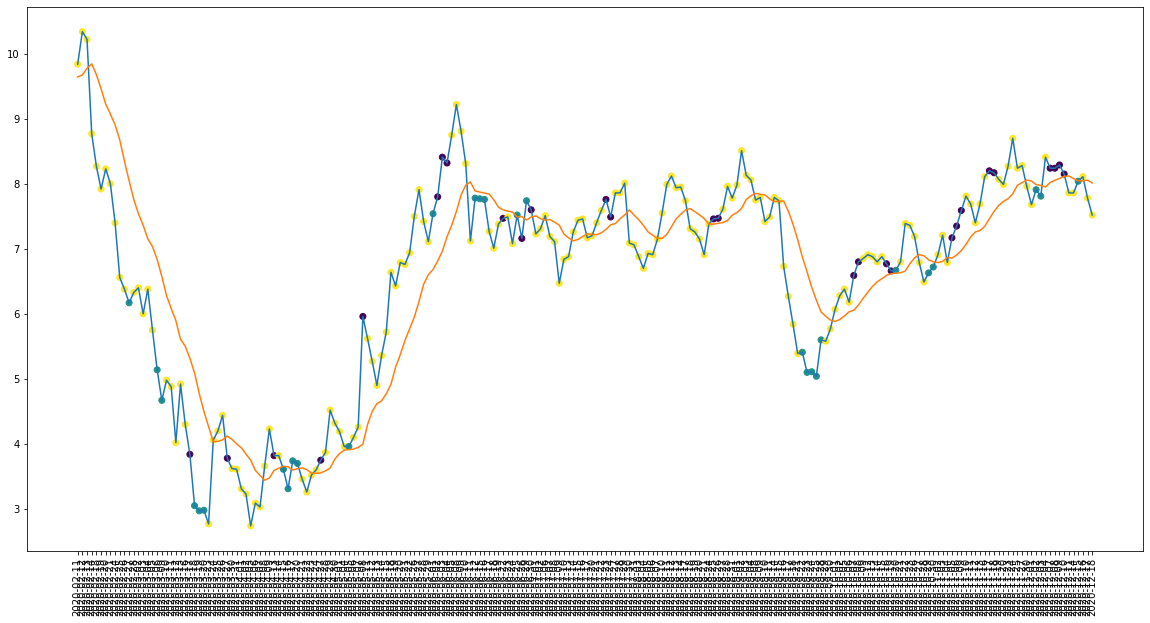

In [255]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

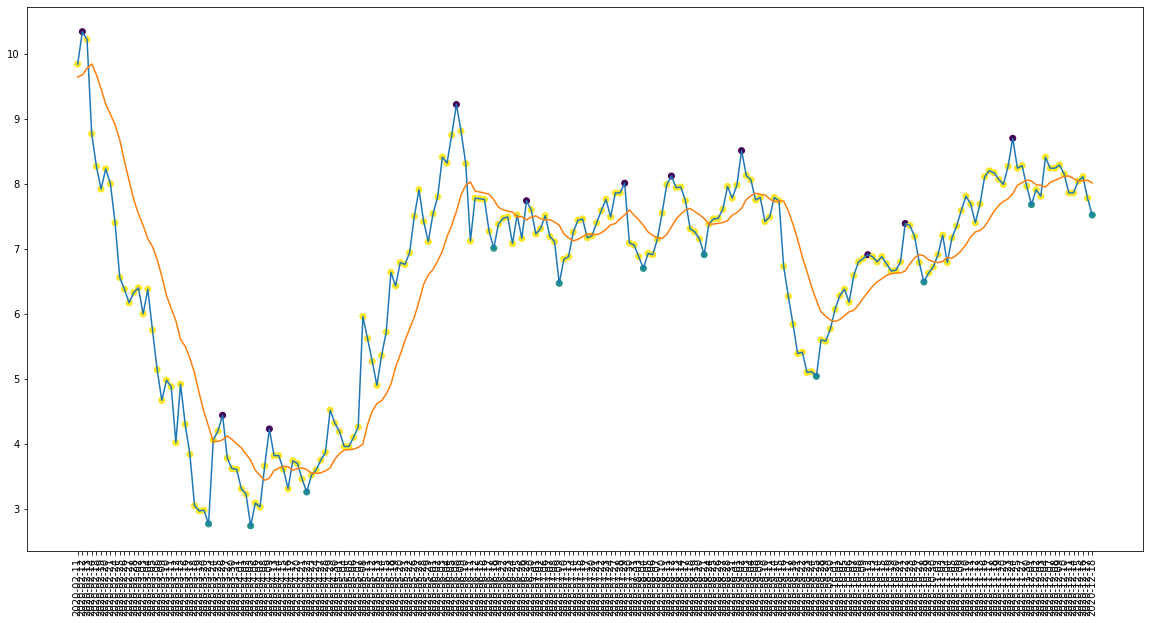

In [256]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [257]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 10
actual holds but predicted buy: 26
actual holds but predicted sell: 28
actual predicted holds: 143
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 0.0%
Percentage holds correct: 72.58883248730965%
actual buys: 11
actual sells: 11
actual holds: 197


In [258]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[7.400000095367432, 7.920000076293945, 8.0, 8.229999542236326, 8.270000457763674, 8.770000457763674, 9.84000015258789, 10.220000267028807, 10.34000015258789]
[6.0, 6.170000076293945, 6.329999923706055, 6.380000114440918, 6.4000000953674325, 6.559999942779541, 7.400000095367432, 8.0, 8.229999542236326]
Percentage buys correct: 60.714285714285715%
Percentage sells correct: 50.0%
Percentage holds correct: 82.71604938271605%


In [259]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $6.170000076293945
Shares owned at the moment: 1616
Cash capital at the moment: $1.860396369933369


Stop Loss Activated!

Share price: $6.0
Shares owned at the moment: 0
Cash capital at the moment: $9671.196396369933


Share price: $5.139999866485597
Shares owned at the moment: 1876
Cash capital at the moment: $2.039387531753164


Stop Loss Activated!

Share price: $4.670000076293945
Shares owned at the moment: 0
Cash capital at the moment: $8738.867000265594


Share price: $4.670000076293945
Shares owned at the moment: 1866
Cash capital at the moment: $0.6827525095905003


Stop Loss Activated!

Share price: $4.019999980926514
Shares owned at the moment: 0
Cash capital at the moment: $7481.37408701634


Share price: $3.049999952316284
Shares owned at the moment: 2446
Cash capital at the moment: $0.5583789714537488


Stop Loss Activated!

Share price: $2.7699999809265137
Shares owned at the moment: 0
Cash capital at the moment: $6757.345927446004


Share price: $3.60999989

In [260]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7601.479205735086
profit gained: -23.98520794264914%


In [261]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.600917,33.333333333333336%,11.11111111111111%,63.5%,58.92857142857143%,57.142857142857146%,78.72340425531915%,-9.125151241259664%,-7.777238176262399%
1,0.674419,37.5%,11.11111111111111%,71.21212121212122%,54.90196078431372%,90.9090909090909%,84.9673202614379%,-27.68439793420087%,-48.34563047105195%
2,0.761468,25.0%,22.22222222222222%,80.59701492537313%,55.172413793103445%,86.66666666666667%,87.86127167630057%,3.9843991503118925%,-5.545324129943856%
3,0.800000,0.0%,30.0%,87.56476683937824%,50.0%,64.70588235294117%,86.48648648648648%,-20.71219810776589%,-7.669883276367181%
4,0.687204,12.5%,22.22222222222222%,73.19587628865979%,53.84615384615385%,58.62068965517241%,83.2258064516129%,-16.49947977055308%,-10.879329186439518%
5,0.751174,10.0%,0.0%,82.38341968911917%,41.1764705882353%,61.111111111111114%,80.7909604519774%,-10.001312134695109%,-41.56249103630067%
6,0.743119,27.272727272727273%,33.333333333333336%,78.1094527363184%,38.888888888888886%,41.935483870967744%,86.9047619047619%,3.769556171989407%,35.77290673755644%
7,0.716895,10.0%,25.0%,77.66497461928934%,45.45454545454545%,46.15384615384615%,81.17647058823529%,7.158475455837287%,-14.13141708526613%
8,0.582569,12.5%,37.5%,60.89108910891089%,41.666666666666664%,55.55555555555556%,84.21052631578948%,-47.906362918296026%,-23.520909336075793%
9,0.657534,9.090909090909092%,0.0%,72.58883248730965%,60.714285714285715%,50.0%,82.71604938271605%,14.746483490016418%,-23.98520794264914%


In [262]:
experiment

'No OBV LSTM Time Series - cyclic'

In [263]:
log.to_csv('{}.csv'.format(experiment))